Hyperparameter Space:   
1. leanring rates: 1e-2, 1e-3, 1e-4, 1e-5    
3. optimizer: SGD, Adam, RMSDrop   
4. latent dimension: 5%, 10%, 15%, 20%, 50%, 75%   

Main Figures:  
1. 10% top-performed hyperparameter config radar plot, KMUC and UPITT, KUMC and UPITT all model all config f1 score correction.
2. KUMC and UPITT control one hyperparameter and vary on others boxplot, KUMC and UPITT.   
3. t-SNE results of the best config output of each model.
4. Best config, check whether some latent encoding correlates with features.
5. Other distanglement results.

Main Tables:
1. Demographics of 2 centers

# Make Common Dataset

In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import json
from utils import cross_validation_dataloader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
result_folder = '...'

In [3]:
print(torch.__version__)

2.6.0.dev20250104


In [4]:
# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    print("MPS (Metal GPU) is available!")
    
    # Get the MPS device
    device = torch.device("mps")
    print(f"Using device: {device}")
else:
    print("MPS is not available. Running on CPU.")

MPS (Metal GPU) is available!
Using device: mps


In [5]:
with open("col_names.json", "r") as file:
    loaded_col_names = json.load(file)

# Extract lists
feature_space = loaded_col_names["feature_space"]
label_col_names = loaded_col_names["label_col_names"]

In [6]:
n_labels = len(label_col_names)

In [7]:
len(feature_space)

579

In [8]:
df = pd.read_csv('./internal_dataset.csv')

In [9]:
df[label_col_names[0]].value_counts()

0.0    12116
1.0     1636
Name: AKI_LABEL, dtype: int64

In [10]:
df[label_col_names[1]].value_counts()

0.0    12013
1.0     1739
Name: MORT_1_YEAR, dtype: int64

In [ ]:
data_splits = cross_validation_dataloader(df, 5, 256, feature_space, label_col_names)

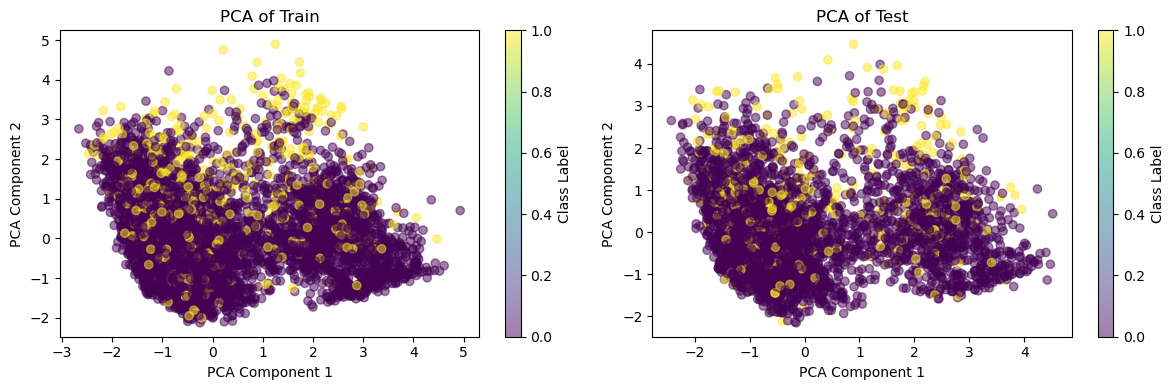

In [36]:
pca = PCA(n_components=2)
# here in data_splits[0][0] represents the first CV setting and we take the train part
# data_splits[0][2] is for the test dataset
X_train_PCA = pca.fit_transform(data_splits[0][0].dataset.features)
X_test_PCA = pca.transform(data_splits[0][2].dataset.features)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# here we only check the AKI onset label which is 
# data_splits[0][0].dataset.labels[:, 0]
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], 
            c=data_splits[0][0].dataset.labels[:, 0], 
            cmap='viridis', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Train')
plt.colorbar(label='Class Label')

plt.subplot(1, 2, 2)
plt.scatter(X_test_PCA[:, 0], X_test_PCA[:, 1], c=data_splits[0][2].dataset.labels[:, 0], 
            cmap='viridis', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Test')
plt.colorbar(label='Class Label')
plt.tight_layout()
plt.show()

In [37]:
for train_loader, val_loader, test_loader in data_splits:
    for batch_data, batch_labels in train_loader:
        print("shape of data:", batch_data.shape)
        print("shape of labels:", batch_labels.shape)
        break
    break

shape of data: torch.Size([256, 579])
shape of labels: torch.Size([256, 2])


# Generate Hyperparameter Space

In [38]:
# ranges we want to test for each hyper-parameter
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
optimizers = ['RMSprop', 'Adam', 'Adamax']
latents = [0.02, 0.05, 0.10, 0.15, 0.30, 0.50, 0.75]
activations = ['sigmoid', 'relu']

In [39]:
# generate all configs in form of dict and store in a dict
config_space = dict()
idx = 0
for lr in lrs:
    for opt in optimizers:
        for lat in latents:
            for activation in activations:
                config = {
                    'learning_rate': lr,
                    'optimizer': opt,
                    'latent': lat,
                    'activation': activation,
                }
                config_space[idx] = config
                idx += 1

In [40]:
len(config_space)

168

In [41]:
with open('./configurations.pkl', 'wb') as file:
    pickle.dump(config_space, file)

# Define Train Function

In [42]:
# main function to train a model, each model has its own train_step
def train(model, optimizer, learning_rate, activation, train_step, val_step, 
          train_loader, val_loader, weight_decay, device):
    
    optimizer = define_optimizer(model, optimizer, learning_rate, weight_decay)
    n_epochs = 2000

    #use early stopping
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    min_increment = 5e-5

    with tqdm(range(n_epochs), desc="Training", leave=False) as t:
        for epoch in t:
            train_loss = train_step(model, train_loader, optimizer, device, activation = activation)
            val_loss = val_step(model, val_loader, device)
            
            # tqdm related function
            t.set_postfix(train_loss=train_loss, val_loss=val_loss)

            # if any loss is inf, fail to converge, directly jump out of epoches, 
            # return false
            if val_loss == float('inf'):
                return False, float('inf')

            # Early stopping check: if the increment is still above the
            # the minimum increment threshold, set the counter to zero and
            # continue training
            if val_loss < best_val_loss - min_increment:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            # check whether running out of patience
            if patience_counter >= patience:
                break
            
    # model converged, return True
    return True, float(round(best_val_loss, 3))

In [43]:
# return the optimizer with parameter setted
def define_optimizer(model, optimizer, learning_rate, weight_decay):
    
    optimizer_dict = {
        'Adamax': torch.optim.Adamax,
        'Adam': torch.optim.Adam,
        'RMSprop': torch.optim.RMSprop,
    }
    
    return optimizer_dict[optimizer](model.parameters(), lr = learning_rate, weight_decay = weight_decay)

# Evaluation Functions

In [44]:
import gc
# AE net architecture remains consistent across all models
from AE_nn import AE
from AE_utils import train_step_AE, val_step_AE
from DAE_utils import train_step_DAE, val_step_DAE
from CAE_utils import train_step_CAE, val_step_CAE
from SAE_utils import train_step_SAE, val_step_SAE
from RAE_utils import train_step_RAE, val_step_RAE

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, log_loss, roc_auc_score, average_precision_score

In [46]:
model_names = ['AE', 'DAE', 'CAE', 'SAE', 'RAE']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
# different neighborhood sizes, we only use Euc here
knn_model_dict = {
    'Euc_5': KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean'),
    'Euc_10': KNeighborsClassifier(n_neighbors = 10, metric = 'euclidean'),
    'Euc_15': KNeighborsClassifier(n_neighbors = 15, metric = 'euclidean'),
    'Euc_20': KNeighborsClassifier(n_neighbors = 20, metric = 'euclidean'),
}

In [48]:
def evaluate_KNN_and_cluster(train_loader, test_loader, model):
    # transform data by models
    # note that we have 3 labels here
    X_train_AE, y_train_AE = get_transformed_data(train_loader, model)
    X_test_AE, y_test_AE = get_transformed_data(test_loader, model)
    
    results = dict()
    results['F1'] = []
    results['AUROC'] = []
    results['AUPRC'] = []

    # use different KNN model with different neighborhood sizes to evaluate the quality of the similar patients 
    with tqdm(knn_model_dict.items(), desc="Evaluating KNN models", leave=False) as t:
        for name, knn_model in t:
            f1s, aurocs, auprcs = knn_evaluation(knn_model, X_train_AE, y_train_AE, X_test_AE, y_test_AE)
            results['F1'].append(f1s)
            results['AUROC'].append(aurocs)
            results['AUPRC'].append(auprcs)

    return results

In [49]:
def get_transformed_data(dataloader, model):
    if model is not None:
        model.eval()
        
    features = dataloader.dataset.features.to(device)
    labels = dataloader.dataset.labels.to(device)
    
    outputs = model(features)
    embedding = outputs[0]
    embedding = embedding.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    return embedding, labels

In [50]:
def knn_evaluation(knn_model, X_train, y_train, X_test, y_test):
    
    if len(y_train.shape) < 2:
        # if we have single label
        n_labels = 1
        y_train, y_test = y_train.view(-1, 1), y_test.view(-1, 1)
    else:
        # we have multiple labels here
        n_labels = y_train.shape[1]
        
    f1_l = []
    auroc_l = []
    auprc_l = []
    
    for l in range(n_labels):
    # fit model on training set
        y_train_single = y_train[:, l]
        y_test_single = y_test[:, l]
        
        knn_model.fit(X_train, y_train_single)
        # make prediction on test set
        yhat = knn_model.predict(X_test)
        yprob = knn_model.predict_proba(X_test)[:, 1]

        # calculate accuracy
        f1 = f1_score(y_test_single, yhat, zero_division = 0)
        f1_l.append(f1)
        auroc = roc_auc_score(y_test_single, yprob)
        auroc_l.append(auroc)
        auprc = average_precision_score(y_test_single, yprob)
        auprc_l.append(auprc)

    return f1_l, auroc_l, auprc_l

In [51]:
def compute_BCE_loss_on_positive_labels(y_test, y_test_pred_probs):
    assert len(y_test) == len(y_test_pred_probs)
    y_test, y_test_pred_probs = np.array(y_test), np.array(y_test_pred_probs)
    
    y_test_positive = y_test[y_test == 1]
    y_pred_probs_positive = y_test_pred_probs[y_test == 1]

    
    positive_log_loss = log_loss(y_test_positive, y_pred_probs_positive, labels=[0, 1])
    return positive_log_loss

In [52]:
def empty_space(AE_model):
    del AE_model
    gc.collect()
    torch.cuda.empty_cache()

# Get Performance from Raw Data

In [53]:
# label_idx is the i-th label we want to evalute on
def evaluate_raw_data_performance(data_splits, label_idx):
    # collect results from CV
    raw_performance_dfs = []
    
    for train_loader, _, test_loader in (data_splits):
        # reconstruct train and test, we only use the AKI onset as the target
        X_train_raw = train_loader.dataset.features
        y_train_raw = train_loader.dataset.labels[:, label_idx]
        X_test_raw = test_loader.dataset.features
        y_test_raw = test_loader.dataset.labels[:, label_idx]
    
        raw_performance = pd.DataFrame(0.0, index = list(knn_model_dict.keys()),
                                columns = ['F1', 'AUROC', 'AUPRC'])

        for name, knn_model in tqdm(knn_model_dict.items()):
            f1s, aurocs, auprcs = knn_evaluation(knn_model, X_train_raw, y_train_raw, X_test_raw, y_test_raw)
            raw_performance.loc[name, 'F1'] = f1s[0]
            raw_performance.loc[name, 'AUROC'] = aurocs[0]
            raw_performance.loc[name, 'AUPRC'] = auprcs[0]

        
        raw_performance_dfs.append(raw_performance)
    
    performance_arrs = [df.to_numpy() for df in raw_performance_dfs]

    # Compute the mean across the stacked arrays
    raw_performance_mean = np.mean(performance_arrs, axis=0)
    raw_performance_std = np.std(performance_arrs, axis=0)

    # Convert back to a DataFrame
    performance_mean = pd.DataFrame(raw_performance_mean, columns=[col+'_mean_%s'%(label_idx) for col in raw_performance_dfs[0].columns])
    performance_std = pd.DataFrame(raw_performance_std, columns=[col+'_std_%s'%(label_idx) for col in raw_performance_dfs[0].columns])
    
    return performance_mean, performance_std


In [54]:
performance_mean_label_1, performance_std_label_1 = evaluate_raw_data_performance(data_splits, 0)

100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


In [55]:
performance_mean_label_2, performance_std_label_2 = evaluate_raw_data_performance(data_splits, 1)

100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


In [56]:
raw_data_performance = pd.concat([performance_mean_label_1, performance_std_label_1, performance_mean_label_2, performance_std_label_2], axis = 1)

In [57]:
raw_data_performance

,F1_mean_0,AUROC_mean_0,AUPRC_mean_0,F1_std_0,AUROC_std_0,AUPRC_std_0,F1_mean_1,AUROC_mean_1,AUPRC_mean_1,F1_std_1,AUROC_std_1,AUPRC_std_1
0,0.315151,0.674349,0.274050,0.015124,0.014334,0.017304,0.096502,0.627546,0.196241,0.008875,0.013321,0.019345
1,0.285774,0.687938,0.282306,0.004498,0.011599,0.022638,0.019353,0.667914,0.223132,0.006473,0.008153,0.018003
2,0.266861,0.685624,0.281282,0.012651,0.011197,0.027902,0.016139,0.687418,0.235393,0.006507,0.006981,0.021788
3,0.252558,0.678722,0.260800,0.014109,0.015813,0.019579,0.001199,0.694598,0.239728,0.001696,0.005458,0.021655


In [58]:
raw_data_performance.to_csv(result_folder + 'raw_data_performance.csv', index = True)

# Get Performance from PCA Data

In [36]:
from sklearn.decomposition import PCA

In [37]:
df_PCA = pd.read_csv('./internal_dataset.csv')
pca = PCA(n_components=0.99) # use PCA to transform data
df_feature_PCA = pca.fit_transform(df_PCA[feature_space])
PCA_columns = [f'PC{i+1}' for i in range(df_feature_PCA.shape[1])]
df_PCA_results = pd.DataFrame(df_feature_PCA, columns=PCA_columns)

for label in label_col_names:
    df_PCA_results[label] = df_PCA[label]

In [ ]:
data_splits_PCA = cross_validation_dataloader(df_PCA_results, 5, 256, PCA_columns, label_col_names)

In [39]:
# performance_mean_label_1_PCA, performance_std_label_1_PCA, _, _, _ = evaluate_raw_data_performance(data_splits_PCA, 0)
performance_mean_label_1_PCA, performance_std_label_1_PCA = evaluate_raw_data_performance(data_splits_PCA, 0)

100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


In [40]:
# performance_mean_label_2_PCA, performance_std_label_2_PCA, _, _, _ = evaluate_raw_data_performance(data_splits_PCA, 1)
performance_mean_label_2_PCA, performance_std_label_2_PCA, = evaluate_raw_data_performance(data_splits_PCA, 1)

100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


In [41]:
raw_data_performance_PCA = pd.concat([performance_mean_label_1_PCA, performance_std_label_1_PCA, performance_mean_label_2_PCA, performance_std_label_2_PCA], axis = 1)

In [42]:
raw_data_performance_PCA

,F1_mean_0,AUROC_mean_0,AUPRC_mean_0,F1_std_0,AUROC_std_0,AUPRC_std_0,F1_mean_1,AUROC_mean_1,AUPRC_mean_1,F1_std_1,AUROC_std_1,AUPRC_std_1
0,0.320399,0.677553,0.281824,0.017487,0.014614,0.021736,0.095018,0.625974,0.192406,0.011824,0.012393,0.017874
1,0.290563,0.689892,0.290517,0.011262,0.011169,0.027341,0.026414,0.669508,0.225037,0.014088,0.008993,0.019058
2,0.270928,0.686869,0.287478,0.015416,0.013192,0.029452,0.016095,0.686420,0.234502,0.008659,0.006019,0.021271
3,0.256797,0.681598,0.268832,0.013019,0.016017,0.022624,0.002245,0.695412,0.242631,0.001598,0.007296,0.027254


In [43]:
raw_data_performance_PCA.to_csv(result_folder + 'raw_data_performance_PCA.csv', index = True)

# Evaluation

In [44]:
torch.cuda.manual_seed_all(42)

In [45]:
def evaluate_models_main(model_name, activation, weight_decay, train_step_AE, val_step_AE):
    final_results_dict = dict()
    AE_results_cv = []
    
    # loop through hyperparameters
    for i, config in config_space.items():
        
        # get hyperparameters
        input_dim = len(feature_space)
        latent_dim = int(config['latent'] * input_dim)
        learning_rate = config['learning_rate']
        optimizer_name = config['optimizer']
        activation = config['activation']
        print('i = %s, lr = %s, opt = %s, latent_pct = %s, activation = %s, '%(i, learning_rate, optimizer_name, 
                                                                               config['latent'], activation))
        
        for train_loader, val_loader, test_loader in (data_splits):
            AE_model = AE(input_dim, latent_dim, activation).to(device)
            AE_converged, AE_val_loss = train(AE_model, optimizer_name, learning_rate, activation,
                                              train_step_AE, val_step_AE,
                                              train_loader, val_loader, weight_decay, device)
            
            # evaluate model by patient similarity KNN
            if AE_converged:
                AE_results = evaluate_KNN_and_cluster(train_loader, test_loader, AE_model)
                AE_results['val_loss'] = AE_val_loss
                AE_results_cv.append(AE_results)
            else:
                AE_results = None
            
            empty_space(AE_model)
            
        AE_perf_mean, AE_perf_std = avg_performance_dict(AE_results_cv)
        final_results_dict[i] = {'performance mean': AE_perf_mean, 'performance std': AE_perf_std}
        print('%s mean='%(model_name), AE_perf_mean)
        
    return final_results_dict

In [46]:
from collections import defaultdict

def avg_performance_dict(dicts):
    # Initialize a defaultdict for accumulating sums and counts
    accumulated = defaultdict(list)

    # Accumulate values from all dictionaries
    for d in dicts:
        for key, value in d.items():
            accumulated[key].append(value)

    # Calculate the mean for each key
    mean_dict = {}
    std_dict = {}
    for key, values in accumulated.items():
        if isinstance(values[0], list):
            # Compute the element-wise mean for lists
            mean_dict[key] = np.round(np.mean(values, axis=0), 3).tolist()
            std_dict[key] = np.round(np.std(values, axis=0), 3).tolist()
        else:
            # Compute the mean for single values
            mean_dict[key] = np.round(np.mean(values), 3)
            std_dict[key] = np.round(np.std(values), 3)
    return mean_dict, std_dict

In [47]:
model_funcs = {
    'AE': {'train': train_step_AE, 'val': val_step_AE},
    'DAE': {'train': train_step_DAE, 'val': val_step_DAE},
    'CAE': {'train': train_step_CAE, 'val': val_step_CAE},
    'SAE': {'train': train_step_SAE, 'val': val_step_SAE},
    'RAE': {'train': train_step_RAE, 'val': val_step_RAE},
}

# Main Run

In [ ]:
final_results_dict_collection = []
for model_name in model_names:
    # define train and val funcs
    model_train_step = model_funcs[model_name]['train']
    model_val_step = model_funcs[model_name]['val']
        
    #define weight decay 
    if model_name == 'RAE':
        weight_decay = 0.03
    else:
        weight_decay = 0
    
    final_results_dict = evaluate_models_main(model_name, activation, weight_decay, 
                                              model_train_step, model_val_step) 
    # save results
    final_results_dict_collection.append(final_results_dict)
    with open(result_folder + '%s_results.pkl'%(model_name), 'wb') as file:
        pickle.dump(final_results_dict, file)

i = 0, lr = 0.01, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.687, 0.629], [0.715, 0.666], [0.726, 0.677], [0.732, 0.688]], 'AUPRC': [[0.322, 0.182], [0.356, 0.208], [0.368, 0.218], [0.376, 0.228]], 'val_loss': 0.031}
i = 1, lr = 0.01, opt = RMSprop, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.672, 0.611], [0.7, 0.645], [0.707, 0.658], [0.714, 0.667]], 'AUPRC': [[0.298, 0.172], [0.335, 0.194], [0.351, 0.204], [0.358, 0.213]], 'val_loss': 0.034}
i = 2, lr = 0.01, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.678, 0.619], [0.706, 0.654], [0.715, 0.669], [0.721, 0.679]], 'AUPRC': [[0.301, 0.179], [0.342, 0.201], [0.358, 0.213], [0.362, 0.222]], 'val_loss': 0.03}
i = 3, lr = 0.01, opt = RMSprop, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.62], [0.708, 0.657], [0.718, 0.673], [0.725, 0.682]], 'AUPRC': [[0.304, 0.182], [0.346, 0.206], [0.362, 0.219], [0.368, 0.227]], 'val_loss': 0.03}
i = 4, lr = 0.01, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.625], [0.71, 0.662], [0.721, 0.679], [0.726, 0.689]], 'AUPRC': [[0.306, 0.184], [0.346, 0.21], [0.36, 0.223], [0.364, 0.233]], 'val_loss': 0.027}
i = 5, lr = 0.01, opt = RMSprop, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.684, 0.627], [0.712, 0.665], [0.723, 0.681], [0.728, 0.691]], 'AUPRC': [[0.31, 0.186], [0.349, 0.211], [0.362, 0.225], [0.366, 0.235]], 'val_loss': 0.026}
i = 6, lr = 0.01, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.686, 0.629], [0.712, 0.668], [0.722, 0.685], [0.726, 0.694]], 'AUPRC': [[0.309, 0.187], [0.345, 0.213], [0.355, 0.227], [0.358, 0.237]], 'val_loss': 0.024}
i = 7, lr = 0.01, opt = RMSprop, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.686, 0.629], [0.713, 0.669], [0.723, 0.686], [0.727, 0.696]], 'AUPRC': [[0.312, 0.188], [0.346, 0.214], [0.356, 0.228], [0.36, 0.239]], 'val_loss': 0.024}
i = 8, lr = 0.01, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.685, 0.631], [0.711, 0.67], [0.719, 0.687], [0.722, 0.697]], 'AUPRC': [[0.308, 0.19], [0.339, 0.217], [0.348, 0.231], [0.35, 0.241]], 'val_loss': 0.022}
i = 9, lr = 0.01, opt = RMSprop, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.685, 0.632], [0.71, 0.671], [0.719, 0.688], [0.722, 0.698]], 'AUPRC': [[0.309, 0.19], [0.339, 0.217], [0.348, 0.231], [0.35, 0.241]], 'val_loss': 0.021}
i = 10, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.685, 0.633], [0.708, 0.671], [0.716, 0.689], [0.719, 0.698]], 'AUPRC': [[0.307, 0.192], [0.334, 0.218], [0.342, 0.232], [0.341, 0.242]], 'val_loss': 0.019}
i = 11, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.685, 0.631], [0.708, 0.67], [0.717, 0.688], [0.719, 0.697]], 'AUPRC': [[0.307, 0.191], [0.335, 0.216], [0.343, 0.231], [0.343, 0.24]], 'val_loss': 0.021}
i = 12, lr = 0.01, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.686, 0.631], [0.71, 0.669], [0.718, 0.687], [0.72, 0.696]], 'AUPRC': [[0.308, 0.191], [0.337, 0.216], [0.346, 0.23], [0.346, 0.24]], 'val_loss': 0.024}
i = 13, lr = 0.01, opt = RMSprop, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.686, 0.631], [0.71, 0.669], [0.718, 0.686], [0.721, 0.694]], 'AUPRC': [[0.309, 0.19], [0.338, 0.215], [0.348, 0.229], [0.349, 0.238]], 'val_loss': 0.027}
i = 14, lr = 0.01, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.625], [0.706, 0.662], [0.715, 0.678], [0.718, 0.687]], 'AUPRC': [[0.307, 0.187], [0.336, 0.211], [0.346, 0.224], [0.347, 0.233]], 'val_loss': 0.028}
i = 15, lr = 0.01, opt = Adam, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.625], [0.705, 0.661], [0.714, 0.678], [0.718, 0.687]], 'AUPRC': [[0.305, 0.186], [0.336, 0.21], [0.346, 0.223], [0.348, 0.232]], 'val_loss': 0.028}
i = 16, lr = 0.01, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.625], [0.705, 0.661], [0.714, 0.678], [0.718, 0.687]], 'AUPRC': [[0.306, 0.186], [0.337, 0.21], [0.347, 0.223], [0.349, 0.231]], 'val_loss': 0.028}
i = 17, lr = 0.01, opt = Adam, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.625], [0.705, 0.661], [0.715, 0.678], [0.718, 0.687]], 'AUPRC': [[0.306, 0.186], [0.338, 0.209], [0.348, 0.223], [0.35, 0.231]], 'val_loss': 0.028}
i = 18, lr = 0.01, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.625], [0.705, 0.662], [0.715, 0.679], [0.719, 0.688]], 'AUPRC': [[0.307, 0.186], [0.338, 0.21], [0.348, 0.223], [0.35, 0.232]], 'val_loss': 0.028}
i = 19, lr = 0.01, opt = Adam, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.626], [0.705, 0.663], [0.715, 0.679], [0.719, 0.688]], 'AUPRC': [[0.307, 0.186], [0.338, 0.21], [0.349, 0.223], [0.351, 0.232]], 'val_loss': 0.028}
i = 20, lr = 0.01, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.626], [0.705, 0.663], [0.714, 0.679], [0.718, 0.688]], 'AUPRC': [[0.306, 0.187], [0.336, 0.211], [0.346, 0.224], [0.348, 0.232]], 'val_loss': 0.027}
i = 21, lr = 0.01, opt = Adam, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.626], [0.705, 0.662], [0.715, 0.679], [0.719, 0.688]], 'AUPRC': [[0.306, 0.186], [0.337, 0.21], [0.347, 0.223], [0.349, 0.232]], 'val_loss': 0.027}
i = 22, lr = 0.01, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.626], [0.702, 0.663], [0.711, 0.678], [0.714, 0.687]], 'AUPRC': [[0.302, 0.187], [0.331, 0.21], [0.341, 0.223], [0.343, 0.231]], 'val_loss': 0.026}
i = 23, lr = 0.01, opt = Adam, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.626], [0.703, 0.663], [0.712, 0.678], [0.715, 0.686]], 'AUPRC': [[0.303, 0.187], [0.332, 0.21], [0.343, 0.222], [0.345, 0.231]], 'val_loss': 0.027}
i = 24, lr = 0.01, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.627], [0.701, 0.663], [0.709, 0.677], [0.711, 0.685]], 'AUPRC': [[0.299, 0.187], [0.328, 0.21], [0.337, 0.222], [0.339, 0.229]], 'val_loss': 0.026}
i = 25, lr = 0.01, opt = Adam, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.627], [0.702, 0.662], [0.71, 0.677], [0.713, 0.685]], 'AUPRC': [[0.3, 0.187], [0.329, 0.21], [0.339, 0.221], [0.341, 0.229]], 'val_loss': 0.026}
i = 26, lr = 0.01, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.627], [0.701, 0.663], [0.708, 0.677], [0.71, 0.685]], 'AUPRC': [[0.298, 0.187], [0.326, 0.21], [0.336, 0.222], [0.338, 0.23]], 'val_loss': 0.025}
i = 27, lr = 0.01, opt = Adam, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.627], [0.701, 0.663], [0.709, 0.677], [0.712, 0.685]], 'AUPRC': [[0.299, 0.187], [0.327, 0.21], [0.337, 0.222], [0.339, 0.23]], 'val_loss': 0.026}
i = 28, lr = 0.01, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.624], [0.7, 0.659], [0.708, 0.674], [0.711, 0.682]], 'AUPRC': [[0.298, 0.186], [0.327, 0.208], [0.337, 0.219], [0.339, 0.227]], 'val_loss': 0.026}
i = 29, lr = 0.01, opt = Adamax, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.678, 0.624], [0.699, 0.659], [0.708, 0.674], [0.711, 0.681]], 'AUPRC': [[0.297, 0.185], [0.326, 0.208], [0.337, 0.219], [0.339, 0.227]], 'val_loss': 0.027}
i = 30, lr = 0.01, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.624], [0.699, 0.659], [0.708, 0.674], [0.711, 0.682]], 'AUPRC': [[0.298, 0.186], [0.327, 0.208], [0.338, 0.22], [0.34, 0.228]], 'val_loss': 0.027}
i = 31, lr = 0.01, opt = Adamax, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.679, 0.624], [0.7, 0.66], [0.709, 0.674], [0.712, 0.682]], 'AUPRC': [[0.299, 0.186], [0.328, 0.208], [0.339, 0.22], [0.342, 0.228]], 'val_loss': 0.027}
i = 32, lr = 0.01, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.625], [0.7, 0.66], [0.709, 0.675], [0.712, 0.683]], 'AUPRC': [[0.299, 0.186], [0.328, 0.209], [0.339, 0.22], [0.341, 0.228]], 'val_loss': 0.026}
i = 33, lr = 0.01, opt = Adamax, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.625], [0.701, 0.661], [0.71, 0.676], [0.713, 0.684]], 'AUPRC': [[0.3, 0.186], [0.33, 0.209], [0.341, 0.221], [0.343, 0.229]], 'val_loss': 0.026}
i = 34, lr = 0.01, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.625], [0.701, 0.661], [0.709, 0.676], [0.712, 0.684]], 'AUPRC': [[0.3, 0.186], [0.329, 0.209], [0.339, 0.221], [0.341, 0.229]], 'val_loss': 0.026}
i = 35, lr = 0.01, opt = Adamax, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.625], [0.701, 0.661], [0.71, 0.676], [0.713, 0.684]], 'AUPRC': [[0.3, 0.186], [0.33, 0.209], [0.34, 0.221], [0.343, 0.229]], 'val_loss': 0.026}
i = 36, lr = 0.01, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.626], [0.7, 0.661], [0.707, 0.676], [0.71, 0.684]], 'AUPRC': [[0.299, 0.187], [0.327, 0.21], [0.337, 0.221], [0.339, 0.229]], 'val_loss': 0.025}
i = 37, lr = 0.01, opt = Adamax, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.625], [0.7, 0.661], [0.708, 0.676], [0.711, 0.684]], 'AUPRC': [[0.299, 0.186], [0.329, 0.209], [0.338, 0.221], [0.341, 0.229]], 'val_loss': 0.025}
i = 38, lr = 0.01, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.626], [0.698, 0.661], [0.706, 0.675], [0.708, 0.683]], 'AUPRC': [[0.297, 0.187], [0.325, 0.209], [0.335, 0.221], [0.337, 0.228]], 'val_loss': 0.024}
i = 39, lr = 0.01, opt = Adamax, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.679, 0.625], [0.699, 0.661], [0.706, 0.675], [0.709, 0.683]], 'AUPRC': [[0.297, 0.186], [0.326, 0.209], [0.336, 0.22], [0.338, 0.228]], 'val_loss': 0.024}
i = 40, lr = 0.01, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.678, 0.626], [0.697, 0.661], [0.704, 0.675], [0.706, 0.682]], 'AUPRC': [[0.295, 0.187], [0.324, 0.209], [0.333, 0.22], [0.335, 0.227]], 'val_loss': 0.024}
i = 41, lr = 0.01, opt = Adamax, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.679, 0.626], [0.698, 0.661], [0.705, 0.675], [0.707, 0.682]], 'AUPRC': [[0.296, 0.186], [0.325, 0.209], [0.334, 0.22], [0.336, 0.227]], 'val_loss': 0.024}
i = 42, lr = 0.001, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.678, 0.624], [0.697, 0.659], [0.704, 0.673], [0.707, 0.68]], 'AUPRC': [[0.295, 0.185], [0.324, 0.207], [0.334, 0.218], [0.336, 0.226]], 'val_loss': 0.024}
i = 43, lr = 0.001, opt = RMSprop, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.678, 0.624], [0.697, 0.659], [0.705, 0.673], [0.707, 0.68]], 'AUPRC': [[0.296, 0.185], [0.325, 0.207], [0.334, 0.219], [0.337, 0.226]], 'val_loss': 0.024}
i = 44, lr = 0.001, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.678, 0.624], [0.698, 0.659], [0.705, 0.673], [0.708, 0.681]], 'AUPRC': [[0.296, 0.185], [0.325, 0.208], [0.335, 0.219], [0.338, 0.226]], 'val_loss': 0.024}
i = 45, lr = 0.001, opt = RMSprop, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.678, 0.625], [0.698, 0.659], [0.706, 0.674], [0.709, 0.681]], 'AUPRC': [[0.297, 0.186], [0.327, 0.208], [0.336, 0.219], [0.339, 0.227]], 'val_loss': 0.024}
i = 46, lr = 0.001, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.625], [0.699, 0.66], [0.706, 0.674], [0.709, 0.682]], 'AUPRC': [[0.298, 0.186], [0.327, 0.208], [0.337, 0.22], [0.339, 0.227]], 'val_loss': 0.024}
i = 47, lr = 0.001, opt = RMSprop, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.679, 0.625], [0.699, 0.66], [0.707, 0.675], [0.71, 0.682]], 'AUPRC': [[0.299, 0.186], [0.328, 0.209], [0.338, 0.22], [0.341, 0.228]], 'val_loss': 0.024}
i = 48, lr = 0.001, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.626], [0.7, 0.66], [0.707, 0.675], [0.71, 0.683]], 'AUPRC': [[0.299, 0.186], [0.328, 0.209], [0.338, 0.221], [0.34, 0.228]], 'val_loss': 0.024}
i = 49, lr = 0.001, opt = RMSprop, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.626], [0.7, 0.661], [0.708, 0.676], [0.711, 0.683]], 'AUPRC': [[0.3, 0.187], [0.33, 0.209], [0.339, 0.221], [0.341, 0.229]], 'val_loss': 0.023}
i = 50, lr = 0.001, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.626], [0.7, 0.661], [0.707, 0.676], [0.71, 0.683]], 'AUPRC': [[0.299, 0.187], [0.328, 0.21], [0.337, 0.221], [0.339, 0.229]], 'val_loss': 0.023}
i = 51, lr = 0.001, opt = RMSprop, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.626], [0.7, 0.661], [0.708, 0.676], [0.71, 0.684]], 'AUPRC': [[0.299, 0.187], [0.329, 0.21], [0.338, 0.222], [0.34, 0.229]], 'val_loss': 0.023}
i = 52, lr = 0.001, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.626], [0.699, 0.661], [0.706, 0.676], [0.709, 0.683]], 'AUPRC': [[0.298, 0.188], [0.327, 0.21], [0.336, 0.222], [0.338, 0.229]], 'val_loss': 0.022}
i = 53, lr = 0.001, opt = RMSprop, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.627], [0.7, 0.662], [0.707, 0.676], [0.709, 0.684]], 'AUPRC': [[0.299, 0.188], [0.328, 0.21], [0.337, 0.222], [0.339, 0.229]], 'val_loss': 0.022}
i = 54, lr = 0.001, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.627], [0.699, 0.662], [0.706, 0.676], [0.708, 0.683]], 'AUPRC': [[0.297, 0.188], [0.326, 0.211], [0.335, 0.222], [0.337, 0.229]], 'val_loss': 0.022}
i = 55, lr = 0.001, opt = RMSprop, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.627], [0.699, 0.662], [0.706, 0.677], [0.708, 0.684]], 'AUPRC': [[0.298, 0.188], [0.327, 0.211], [0.335, 0.223], [0.337, 0.23]], 'val_loss': 0.021}
i = 56, lr = 0.001, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.626], [0.699, 0.661], [0.706, 0.675], [0.708, 0.682]], 'AUPRC': [[0.297, 0.188], [0.326, 0.21], [0.335, 0.221], [0.337, 0.228]], 'val_loss': 0.022}
i = 57, lr = 0.001, opt = Adam, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.679, 0.626], [0.699, 0.661], [0.706, 0.675], [0.708, 0.682]], 'AUPRC': [[0.298, 0.188], [0.327, 0.21], [0.335, 0.221], [0.338, 0.228]], 'val_loss': 0.022}
i = 58, lr = 0.001, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.625], [0.698, 0.66], [0.706, 0.674], [0.708, 0.682]], 'AUPRC': [[0.297, 0.187], [0.326, 0.209], [0.335, 0.221], [0.338, 0.228]], 'val_loss': 0.022}
i = 59, lr = 0.001, opt = Adam, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.679, 0.625], [0.699, 0.66], [0.706, 0.675], [0.709, 0.682]], 'AUPRC': [[0.298, 0.187], [0.327, 0.209], [0.336, 0.221], [0.339, 0.228]], 'val_loss': 0.022}
i = 60, lr = 0.001, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.679, 0.626], [0.699, 0.66], [0.707, 0.675], [0.709, 0.682]], 'AUPRC': [[0.298, 0.187], [0.328, 0.21], [0.336, 0.221], [0.339, 0.228]], 'val_loss': 0.022}
i = 61, lr = 0.001, opt = Adam, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.626], [0.7, 0.661], [0.707, 0.675], [0.71, 0.683]], 'AUPRC': [[0.299, 0.188], [0.329, 0.21], [0.337, 0.222], [0.34, 0.229]], 'val_loss': 0.022}
i = 62, lr = 0.001, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.626], [0.7, 0.661], [0.707, 0.676], [0.71, 0.683]], 'AUPRC': [[0.299, 0.188], [0.328, 0.211], [0.337, 0.222], [0.339, 0.229]], 'val_loss': 0.022}
i = 63, lr = 0.001, opt = Adam, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.626], [0.7, 0.661], [0.708, 0.676], [0.71, 0.683]], 'AUPRC': [[0.3, 0.188], [0.329, 0.211], [0.338, 0.223], [0.34, 0.23]], 'val_loss': 0.022}
i = 64, lr = 0.001, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.627], [0.7, 0.662], [0.707, 0.676], [0.709, 0.683]], 'AUPRC': [[0.299, 0.188], [0.328, 0.211], [0.337, 0.223], [0.339, 0.229]], 'val_loss': 0.021}
i = 65, lr = 0.001, opt = Adam, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.627], [0.7, 0.662], [0.707, 0.676], [0.71, 0.684]], 'AUPRC': [[0.3, 0.189], [0.329, 0.211], [0.338, 0.223], [0.34, 0.23]], 'val_loss': 0.021}
i = 66, lr = 0.001, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.627], [0.699, 0.662], [0.706, 0.676], [0.708, 0.683]], 'AUPRC': [[0.299, 0.189], [0.327, 0.211], [0.336, 0.223], [0.338, 0.229]], 'val_loss': 0.021}
i = 67, lr = 0.001, opt = Adam, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.627], [0.7, 0.662], [0.707, 0.676], [0.709, 0.684]], 'AUPRC': [[0.299, 0.189], [0.328, 0.211], [0.337, 0.223], [0.339, 0.23]], 'val_loss': 0.021}
i = 68, lr = 0.001, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.627], [0.699, 0.662], [0.706, 0.676], [0.708, 0.683]], 'AUPRC': [[0.298, 0.189], [0.326, 0.211], [0.335, 0.222], [0.337, 0.229]], 'val_loss': 0.02}
i = 69, lr = 0.001, opt = Adam, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.627], [0.699, 0.662], [0.706, 0.676], [0.708, 0.683]], 'AUPRC': [[0.299, 0.189], [0.327, 0.211], [0.336, 0.223], [0.338, 0.229]], 'val_loss': 0.02}
i = 70, lr = 0.001, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.626], [0.699, 0.66], [0.706, 0.675], [0.708, 0.682]], 'AUPRC': [[0.298, 0.188], [0.327, 0.21], [0.336, 0.222], [0.337, 0.228]], 'val_loss': 0.021}
i = 71, lr = 0.001, opt = Adamax, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.626], [0.699, 0.66], [0.706, 0.675], [0.708, 0.682]], 'AUPRC': [[0.299, 0.188], [0.327, 0.21], [0.336, 0.222], [0.338, 0.228]], 'val_loss': 0.021}
i = 72, lr = 0.001, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.626], [0.699, 0.66], [0.706, 0.674], [0.708, 0.681]], 'AUPRC': [[0.299, 0.188], [0.327, 0.21], [0.336, 0.221], [0.338, 0.228]], 'val_loss': 0.021}
i = 73, lr = 0.001, opt = Adamax, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.626], [0.699, 0.66], [0.706, 0.675], [0.709, 0.682]], 'AUPRC': [[0.299, 0.188], [0.328, 0.21], [0.337, 0.221], [0.339, 0.228]], 'val_loss': 0.021}
i = 74, lr = 0.001, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.626], [0.699, 0.66], [0.707, 0.675], [0.709, 0.682]], 'AUPRC': [[0.299, 0.188], [0.328, 0.21], [0.337, 0.222], [0.339, 0.228]], 'val_loss': 0.021}
i = 75, lr = 0.001, opt = Adamax, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.626], [0.7, 0.661], [0.707, 0.675], [0.71, 0.682]], 'AUPRC': [[0.3, 0.188], [0.329, 0.21], [0.338, 0.222], [0.34, 0.229]], 'val_loss': 0.021}
i = 76, lr = 0.001, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.627], [0.7, 0.661], [0.707, 0.676], [0.71, 0.683]], 'AUPRC': [[0.3, 0.188], [0.329, 0.21], [0.338, 0.222], [0.34, 0.229]], 'val_loss': 0.021}
i = 77, lr = 0.001, opt = Adamax, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.627], [0.701, 0.661], [0.708, 0.676], [0.71, 0.683]], 'AUPRC': [[0.301, 0.188], [0.33, 0.211], [0.339, 0.222], [0.341, 0.229]], 'val_loss': 0.021}
i = 78, lr = 0.001, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.627], [0.7, 0.661], [0.707, 0.676], [0.709, 0.683]], 'AUPRC': [[0.3, 0.189], [0.329, 0.211], [0.338, 0.223], [0.339, 0.229]], 'val_loss': 0.02}
i = 79, lr = 0.001, opt = Adamax, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.627], [0.7, 0.661], [0.708, 0.676], [0.71, 0.683]], 'AUPRC': [[0.301, 0.189], [0.329, 0.211], [0.338, 0.223], [0.34, 0.229]], 'val_loss': 0.02}
i = 80, lr = 0.001, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.627], [0.7, 0.661], [0.707, 0.676], [0.709, 0.683]], 'AUPRC': [[0.3, 0.189], [0.328, 0.211], [0.337, 0.223], [0.339, 0.229]], 'val_loss': 0.02}
i = 81, lr = 0.001, opt = Adamax, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.627], [0.7, 0.662], [0.707, 0.676], [0.709, 0.683]], 'AUPRC': [[0.3, 0.189], [0.329, 0.211], [0.338, 0.223], [0.339, 0.229]], 'val_loss': 0.02}
i = 82, lr = 0.001, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.627], [0.699, 0.662], [0.706, 0.676], [0.708, 0.683]], 'AUPRC': [[0.299, 0.189], [0.327, 0.211], [0.336, 0.223], [0.338, 0.229]], 'val_loss': 0.02}
i = 83, lr = 0.001, opt = Adamax, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.628], [0.7, 0.662], [0.706, 0.676], [0.709, 0.683]], 'AUPRC': [[0.3, 0.189], [0.328, 0.211], [0.337, 0.223], [0.339, 0.229]], 'val_loss': 0.019}
i = 84, lr = 0.0001, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.626], [0.699, 0.66], [0.706, 0.675], [0.708, 0.682]], 'AUPRC': [[0.299, 0.189], [0.328, 0.211], [0.337, 0.222], [0.338, 0.228]], 'val_loss': 0.02}
i = 85, lr = 0.0001, opt = RMSprop, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.626], [0.699, 0.66], [0.706, 0.675], [0.709, 0.682]], 'AUPRC': [[0.3, 0.189], [0.328, 0.211], [0.337, 0.222], [0.339, 0.228]], 'val_loss': 0.02}
i = 86, lr = 0.0001, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.68, 0.626], [0.699, 0.66], [0.706, 0.674], [0.709, 0.681]], 'AUPRC': [[0.299, 0.188], [0.328, 0.21], [0.337, 0.221], [0.339, 0.228]], 'val_loss': 0.02}
i = 87, lr = 0.0001, opt = RMSprop, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.68, 0.626], [0.7, 0.66], [0.707, 0.674], [0.709, 0.681]], 'AUPRC': [[0.3, 0.188], [0.329, 0.21], [0.338, 0.222], [0.34, 0.228]], 'val_loss': 0.02}
i = 88, lr = 0.0001, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.626], [0.7, 0.66], [0.707, 0.675], [0.71, 0.681]], 'AUPRC': [[0.3, 0.188], [0.329, 0.21], [0.338, 0.222], [0.34, 0.228]], 'val_loss': 0.02}
i = 89, lr = 0.0001, opt = RMSprop, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.626], [0.7, 0.66], [0.707, 0.675], [0.71, 0.682]], 'AUPRC': [[0.3, 0.189], [0.329, 0.211], [0.339, 0.222], [0.341, 0.229]], 'val_loss': 0.02}
i = 90, lr = 0.0001, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.626], [0.7, 0.661], [0.708, 0.675], [0.71, 0.682]], 'AUPRC': [[0.301, 0.189], [0.33, 0.211], [0.339, 0.223], [0.341, 0.229]], 'val_loss': 0.02}
i = 91, lr = 0.0001, opt = RMSprop, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.626], [0.701, 0.661], [0.708, 0.675], [0.711, 0.682]], 'AUPRC': [[0.301, 0.189], [0.33, 0.211], [0.34, 0.223], [0.341, 0.229]], 'val_loss': 0.02}
i = 92, lr = 0.0001, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.627], [0.701, 0.661], [0.708, 0.676], [0.71, 0.683]], 'AUPRC': [[0.301, 0.189], [0.33, 0.211], [0.339, 0.223], [0.341, 0.229]], 'val_loss': 0.02}
i = 93, lr = 0.0001, opt = RMSprop, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.627], [0.701, 0.661], [0.708, 0.676], [0.711, 0.683]], 'AUPRC': [[0.302, 0.189], [0.331, 0.211], [0.34, 0.223], [0.341, 0.23]], 'val_loss': 0.02}
i = 94, lr = 0.0001, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.627], [0.701, 0.661], [0.708, 0.676], [0.71, 0.683]], 'AUPRC': [[0.301, 0.189], [0.33, 0.211], [0.339, 0.223], [0.34, 0.23]], 'val_loss': 0.019}
i = 95, lr = 0.0001, opt = RMSprop, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.627], [0.701, 0.661], [0.708, 0.676], [0.71, 0.683]], 'AUPRC': [[0.302, 0.189], [0.33, 0.212], [0.339, 0.223], [0.341, 0.23]], 'val_loss': 0.019}
i = 96, lr = 0.0001, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.627], [0.7, 0.661], [0.707, 0.676], [0.71, 0.683]], 'AUPRC': [[0.301, 0.189], [0.329, 0.212], [0.338, 0.223], [0.34, 0.23]], 'val_loss': 0.019}
i = 97, lr = 0.0001, opt = RMSprop, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.627], [0.701, 0.661], [0.707, 0.676], [0.71, 0.683]], 'AUPRC': [[0.301, 0.189], [0.33, 0.212], [0.338, 0.223], [0.34, 0.23]], 'val_loss': 0.019}
i = 98, lr = 0.0001, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.626], [0.7, 0.66], [0.707, 0.675], [0.709, 0.682]], 'AUPRC': [[0.301, 0.189], [0.329, 0.211], [0.338, 0.223], [0.34, 0.229]], 'val_loss': 0.019}
i = 99, lr = 0.0001, opt = Adam, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.626], [0.7, 0.66], [0.707, 0.675], [0.709, 0.682]], 'AUPRC': [[0.301, 0.189], [0.329, 0.211], [0.338, 0.223], [0.34, 0.229]], 'val_loss': 0.019}
i = 100, lr = 0.0001, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.626], [0.7, 0.66], [0.707, 0.674], [0.709, 0.681]], 'AUPRC': [[0.301, 0.188], [0.329, 0.211], [0.338, 0.222], [0.34, 0.229]], 'val_loss': 0.02}
i = 101, lr = 0.0001, opt = Adam, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.626], [0.7, 0.66], [0.707, 0.675], [0.71, 0.681]], 'AUPRC': [[0.301, 0.189], [0.33, 0.211], [0.339, 0.222], [0.341, 0.229]], 'val_loss': 0.02}
i = 102, lr = 0.0001, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.626], [0.7, 0.66], [0.708, 0.675], [0.71, 0.682]], 'AUPRC': [[0.302, 0.189], [0.33, 0.211], [0.339, 0.223], [0.341, 0.229]], 'val_loss': 0.02}
i = 103, lr = 0.0001, opt = Adam, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.626], [0.701, 0.66], [0.708, 0.675], [0.71, 0.682]], 'AUPRC': [[0.302, 0.189], [0.331, 0.211], [0.34, 0.223], [0.342, 0.229]], 'val_loss': 0.02}
i = 104, lr = 0.0001, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.626], [0.701, 0.66], [0.708, 0.675], [0.711, 0.682]], 'AUPRC': [[0.302, 0.189], [0.331, 0.211], [0.34, 0.223], [0.342, 0.229]], 'val_loss': 0.02}
i = 105, lr = 0.0001, opt = Adam, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.626], [0.701, 0.661], [0.708, 0.675], [0.711, 0.682]], 'AUPRC': [[0.303, 0.189], [0.331, 0.211], [0.34, 0.223], [0.342, 0.23]], 'val_loss': 0.019}
i = 106, lr = 0.0001, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.626], [0.701, 0.661], [0.708, 0.676], [0.711, 0.683]], 'AUPRC': [[0.302, 0.189], [0.331, 0.212], [0.34, 0.223], [0.342, 0.23]], 'val_loss': 0.019}
i = 107, lr = 0.0001, opt = Adam, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.626], [0.701, 0.661], [0.709, 0.676], [0.711, 0.683]], 'AUPRC': [[0.303, 0.189], [0.332, 0.212], [0.341, 0.224], [0.342, 0.23]], 'val_loss': 0.019}
i = 108, lr = 0.0001, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.627], [0.701, 0.661], [0.708, 0.676], [0.711, 0.683]], 'AUPRC': [[0.303, 0.189], [0.331, 0.212], [0.34, 0.224], [0.342, 0.23]], 'val_loss': 0.019}
i = 109, lr = 0.0001, opt = Adam, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.627], [0.701, 0.661], [0.708, 0.676], [0.711, 0.683]], 'AUPRC': [[0.303, 0.189], [0.332, 0.212], [0.34, 0.224], [0.342, 0.23]], 'val_loss': 0.019}
i = 110, lr = 0.0001, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.627], [0.701, 0.661], [0.708, 0.676], [0.71, 0.683]], 'AUPRC': [[0.302, 0.189], [0.331, 0.212], [0.339, 0.224], [0.341, 0.23]], 'val_loss': 0.019}
i = 111, lr = 0.0001, opt = Adam, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.627], [0.701, 0.661], [0.708, 0.676], [0.711, 0.683]], 'AUPRC': [[0.303, 0.189], [0.331, 0.212], [0.34, 0.224], [0.341, 0.23]], 'val_loss': 0.019}
i = 112, lr = 0.0001, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.626], [0.701, 0.66], [0.708, 0.675], [0.71, 0.682]], 'AUPRC': [[0.302, 0.189], [0.331, 0.211], [0.34, 0.223], [0.341, 0.23]], 'val_loss': 0.019}
i = 113, lr = 0.0001, opt = Adamax, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.626], [0.701, 0.66], [0.708, 0.675], [0.711, 0.682]], 'AUPRC': [[0.302, 0.189], [0.331, 0.211], [0.34, 0.223], [0.341, 0.23]], 'val_loss': 0.019}
i = 114, lr = 0.0001, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.681, 0.626], [0.701, 0.66], [0.708, 0.675], [0.711, 0.682]], 'AUPRC': [[0.302, 0.189], [0.331, 0.211], [0.34, 0.223], [0.342, 0.229]], 'val_loss': 0.019}
i = 115, lr = 0.0001, opt = Adamax, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.681, 0.626], [0.701, 0.66], [0.708, 0.675], [0.711, 0.682]], 'AUPRC': [[0.303, 0.189], [0.331, 0.211], [0.34, 0.223], [0.342, 0.229]], 'val_loss': 0.019}
i = 116, lr = 0.0001, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.626], [0.701, 0.66], [0.708, 0.675], [0.711, 0.682]], 'AUPRC': [[0.303, 0.189], [0.332, 0.211], [0.341, 0.223], [0.342, 0.23]], 'val_loss': 0.019}
i = 117, lr = 0.0001, opt = Adamax, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.626], [0.701, 0.66], [0.709, 0.675], [0.712, 0.682]], 'AUPRC': [[0.303, 0.189], [0.332, 0.211], [0.341, 0.223], [0.343, 0.23]], 'val_loss': 0.019}
i = 118, lr = 0.0001, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.626], [0.702, 0.661], [0.709, 0.675], [0.712, 0.683]], 'AUPRC': [[0.303, 0.189], [0.332, 0.212], [0.341, 0.223], [0.343, 0.23]], 'val_loss': 0.019}
i = 119, lr = 0.0001, opt = Adamax, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.626], [0.702, 0.661], [0.709, 0.676], [0.712, 0.683]], 'AUPRC': [[0.304, 0.189], [0.333, 0.212], [0.342, 0.224], [0.344, 0.23]], 'val_loss': 0.019}
i = 120, lr = 0.0001, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.626], [0.702, 0.661], [0.709, 0.676], [0.712, 0.683]], 'AUPRC': [[0.304, 0.189], [0.333, 0.212], [0.342, 0.224], [0.344, 0.231]], 'val_loss': 0.019}
i = 121, lr = 0.0001, opt = Adamax, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.626], [0.702, 0.661], [0.71, 0.676], [0.712, 0.683]], 'AUPRC': [[0.304, 0.189], [0.333, 0.212], [0.342, 0.224], [0.344, 0.231]], 'val_loss': 0.019}
i = 122, lr = 0.0001, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.627], [0.702, 0.661], [0.71, 0.676], [0.712, 0.684]], 'AUPRC': [[0.304, 0.189], [0.333, 0.212], [0.342, 0.224], [0.344, 0.231]], 'val_loss': 0.019}
i = 123, lr = 0.0001, opt = Adamax, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.627], [0.702, 0.661], [0.71, 0.676], [0.713, 0.684]], 'AUPRC': [[0.304, 0.189], [0.333, 0.212], [0.342, 0.224], [0.344, 0.231]], 'val_loss': 0.019}
i = 124, lr = 0.0001, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.627], [0.702, 0.662], [0.71, 0.676], [0.712, 0.684]], 'AUPRC': [[0.304, 0.189], [0.333, 0.212], [0.342, 0.224], [0.344, 0.231]], 'val_loss': 0.019}
i = 125, lr = 0.0001, opt = Adamax, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.627], [0.702, 0.662], [0.71, 0.677], [0.713, 0.684]], 'AUPRC': [[0.305, 0.19], [0.333, 0.212], [0.342, 0.224], [0.344, 0.231]], 'val_loss': 0.019}
i = 126, lr = 1e-05, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.626], [0.702, 0.661], [0.709, 0.676], [0.712, 0.683]], 'AUPRC': [[0.304, 0.189], [0.333, 0.212], [0.342, 0.224], [0.344, 0.231]], 'val_loss': 0.019}
i = 127, lr = 1e-05, opt = RMSprop, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.626], [0.702, 0.661], [0.71, 0.676], [0.712, 0.683]], 'AUPRC': [[0.304, 0.189], [0.333, 0.212], [0.342, 0.224], [0.344, 0.23]], 'val_loss': 0.019}
i = 128, lr = 1e-05, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.626], [0.702, 0.66], [0.709, 0.675], [0.712, 0.682]], 'AUPRC': [[0.304, 0.189], [0.333, 0.211], [0.342, 0.223], [0.344, 0.23]], 'val_loss': 0.019}
i = 129, lr = 1e-05, opt = RMSprop, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.626], [0.702, 0.66], [0.71, 0.675], [0.713, 0.682]], 'AUPRC': [[0.304, 0.189], [0.333, 0.211], [0.342, 0.223], [0.344, 0.23]], 'val_loss': 0.019}
i = 130, lr = 1e-05, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.625], [0.702, 0.66], [0.71, 0.675], [0.713, 0.682]], 'AUPRC': [[0.304, 0.189], [0.333, 0.211], [0.342, 0.223], [0.344, 0.23]], 'val_loss': 0.02}
i = 131, lr = 1e-05, opt = RMSprop, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.625], [0.702, 0.66], [0.71, 0.675], [0.713, 0.682]], 'AUPRC': [[0.304, 0.189], [0.334, 0.211], [0.343, 0.223], [0.345, 0.23]], 'val_loss': 0.02}
i = 132, lr = 1e-05, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.625], [0.702, 0.66], [0.71, 0.675], [0.713, 0.682]], 'AUPRC': [[0.304, 0.189], [0.334, 0.211], [0.343, 0.223], [0.345, 0.23]], 'val_loss': 0.02}
i = 133, lr = 1e-05, opt = RMSprop, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.625], [0.703, 0.66], [0.71, 0.675], [0.713, 0.682]], 'AUPRC': [[0.305, 0.189], [0.334, 0.211], [0.343, 0.223], [0.346, 0.23]], 'val_loss': 0.02}
i = 134, lr = 1e-05, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.626], [0.703, 0.66], [0.711, 0.675], [0.714, 0.683]], 'AUPRC': [[0.305, 0.189], [0.335, 0.212], [0.344, 0.223], [0.346, 0.23]], 'val_loss': 0.02}
i = 135, lr = 1e-05, opt = RMSprop, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.626], [0.703, 0.66], [0.711, 0.675], [0.714, 0.683]], 'AUPRC': [[0.305, 0.189], [0.335, 0.212], [0.344, 0.224], [0.346, 0.23]], 'val_loss': 0.02}
i = 136, lr = 1e-05, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.626], [0.703, 0.661], [0.711, 0.676], [0.714, 0.683]], 'AUPRC': [[0.306, 0.189], [0.335, 0.212], [0.345, 0.224], [0.347, 0.231]], 'val_loss': 0.02}
i = 137, lr = 1e-05, opt = RMSprop, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.626], [0.703, 0.661], [0.711, 0.676], [0.714, 0.683]], 'AUPRC': [[0.306, 0.189], [0.336, 0.212], [0.345, 0.224], [0.347, 0.231]], 'val_loss': 0.02}
i = 138, lr = 1e-05, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.626], [0.703, 0.661], [0.711, 0.676], [0.715, 0.683]], 'AUPRC': [[0.306, 0.189], [0.336, 0.212], [0.345, 0.224], [0.347, 0.231]], 'val_loss': 0.02}
i = 139, lr = 1e-05, opt = RMSprop, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.626], [0.703, 0.661], [0.712, 0.676], [0.715, 0.684]], 'AUPRC': [[0.306, 0.189], [0.336, 0.212], [0.345, 0.224], [0.348, 0.231]], 'val_loss': 0.02}
i = 140, lr = 1e-05, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.625], [0.703, 0.66], [0.711, 0.675], [0.715, 0.683]], 'AUPRC': [[0.306, 0.189], [0.336, 0.212], [0.345, 0.224], [0.347, 0.231]], 'val_loss': 0.02}
i = 141, lr = 1e-05, opt = Adam, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.625], [0.703, 0.66], [0.711, 0.675], [0.715, 0.683]], 'AUPRC': [[0.306, 0.189], [0.336, 0.212], [0.345, 0.224], [0.348, 0.231]], 'val_loss': 0.02}
i = 142, lr = 1e-05, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.625], [0.703, 0.66], [0.711, 0.675], [0.714, 0.682]], 'AUPRC': [[0.306, 0.189], [0.336, 0.211], [0.345, 0.223], [0.348, 0.23]], 'val_loss': 0.02}
i = 143, lr = 1e-05, opt = Adam, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.625], [0.703, 0.66], [0.711, 0.675], [0.715, 0.682]], 'AUPRC': [[0.306, 0.189], [0.336, 0.211], [0.346, 0.223], [0.348, 0.23]], 'val_loss': 0.02}
i = 144, lr = 1e-05, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.625], [0.703, 0.66], [0.711, 0.675], [0.715, 0.682]], 'AUPRC': [[0.306, 0.188], [0.336, 0.211], [0.346, 0.223], [0.348, 0.23]], 'val_loss': 0.02}
i = 145, lr = 1e-05, opt = Adam, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.682, 0.625], [0.703, 0.66], [0.712, 0.675], [0.715, 0.682]], 'AUPRC': [[0.306, 0.189], [0.336, 0.211], [0.346, 0.223], [0.348, 0.23]], 'val_loss': 0.02}
i = 146, lr = 1e-05, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.682, 0.625], [0.703, 0.659], [0.712, 0.674], [0.715, 0.682]], 'AUPRC': [[0.306, 0.188], [0.336, 0.211], [0.346, 0.223], [0.349, 0.23]], 'val_loss': 0.021}
i = 147, lr = 1e-05, opt = Adam, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.625], [0.704, 0.66], [0.712, 0.675], [0.715, 0.682]], 'AUPRC': [[0.306, 0.188], [0.337, 0.211], [0.346, 0.223], [0.349, 0.23]], 'val_loss': 0.021}
i = 148, lr = 1e-05, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.625], [0.704, 0.66], [0.712, 0.675], [0.716, 0.682]], 'AUPRC': [[0.307, 0.189], [0.337, 0.211], [0.347, 0.223], [0.349, 0.23]], 'val_loss': 0.021}
i = 149, lr = 1e-05, opt = Adam, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.625], [0.704, 0.66], [0.712, 0.675], [0.716, 0.683]], 'AUPRC': [[0.307, 0.189], [0.337, 0.212], [0.347, 0.224], [0.35, 0.231]], 'val_loss': 0.021}
i = 150, lr = 1e-05, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.625], [0.704, 0.66], [0.712, 0.675], [0.716, 0.683]], 'AUPRC': [[0.307, 0.189], [0.338, 0.212], [0.347, 0.224], [0.35, 0.231]], 'val_loss': 0.021}
i = 151, lr = 1e-05, opt = Adam, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.625], [0.704, 0.66], [0.713, 0.675], [0.716, 0.683]], 'AUPRC': [[0.307, 0.189], [0.338, 0.212], [0.348, 0.224], [0.35, 0.231]], 'val_loss': 0.021}
i = 152, lr = 1e-05, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.626], [0.704, 0.66], [0.713, 0.676], [0.716, 0.683]], 'AUPRC': [[0.308, 0.189], [0.338, 0.212], [0.348, 0.224], [0.35, 0.231]], 'val_loss': 0.02}
i = 153, lr = 1e-05, opt = Adam, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.626], [0.704, 0.661], [0.713, 0.676], [0.717, 0.683]], 'AUPRC': [[0.308, 0.189], [0.338, 0.212], [0.348, 0.224], [0.351, 0.231]], 'val_loss': 0.02}
i = 154, lr = 1e-05, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.625], [0.704, 0.66], [0.713, 0.675], [0.716, 0.683]], 'AUPRC': [[0.308, 0.189], [0.338, 0.212], [0.348, 0.224], [0.35, 0.231]], 'val_loss': 0.021}
i = 155, lr = 1e-05, opt = Adamax, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.625], [0.704, 0.659], [0.712, 0.675], [0.716, 0.682]], 'AUPRC': [[0.307, 0.189], [0.338, 0.211], [0.348, 0.223], [0.35, 0.23]], 'val_loss': 0.021}
i = 156, lr = 1e-05, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.625], [0.704, 0.659], [0.712, 0.674], [0.716, 0.682]], 'AUPRC': [[0.307, 0.188], [0.338, 0.211], [0.348, 0.223], [0.35, 0.23]], 'val_loss': 0.021}
i = 157, lr = 1e-05, opt = Adamax, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.625], [0.704, 0.659], [0.712, 0.674], [0.716, 0.682]], 'AUPRC': [[0.307, 0.188], [0.338, 0.211], [0.348, 0.223], [0.35, 0.23]], 'val_loss': 0.021}
i = 158, lr = 1e-05, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.624], [0.704, 0.659], [0.712, 0.674], [0.716, 0.681]], 'AUPRC': [[0.307, 0.188], [0.338, 0.211], [0.348, 0.223], [0.35, 0.23]], 'val_loss': 0.021}
i = 159, lr = 1e-05, opt = Adamax, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.624], [0.704, 0.659], [0.713, 0.674], [0.716, 0.682]], 'AUPRC': [[0.307, 0.188], [0.338, 0.211], [0.348, 0.223], [0.351, 0.23]], 'val_loss': 0.021}
i = 160, lr = 1e-05, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.624], [0.704, 0.659], [0.713, 0.674], [0.716, 0.682]], 'AUPRC': [[0.307, 0.188], [0.338, 0.211], [0.348, 0.223], [0.351, 0.23]], 'val_loss': 0.021}
i = 161, lr = 1e-05, opt = Adamax, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.624], [0.704, 0.659], [0.713, 0.674], [0.717, 0.682]], 'AUPRC': [[0.308, 0.188], [0.338, 0.211], [0.348, 0.223], [0.351, 0.23]], 'val_loss': 0.021}
i = 162, lr = 1e-05, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.624], [0.704, 0.659], [0.713, 0.674], [0.717, 0.682]], 'AUPRC': [[0.308, 0.188], [0.339, 0.211], [0.349, 0.223], [0.352, 0.23]], 'val_loss': 0.022}
i = 163, lr = 1e-05, opt = Adamax, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.625], [0.704, 0.659], [0.713, 0.674], [0.717, 0.682]], 'AUPRC': [[0.308, 0.188], [0.339, 0.211], [0.349, 0.223], [0.352, 0.23]], 'val_loss': 0.022}
i = 164, lr = 1e-05, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.625], [0.705, 0.659], [0.713, 0.675], [0.717, 0.682]], 'AUPRC': [[0.308, 0.188], [0.339, 0.211], [0.349, 0.223], [0.352, 0.23]], 'val_loss': 0.022}
i = 165, lr = 1e-05, opt = Adamax, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.625], [0.705, 0.659], [0.714, 0.675], [0.717, 0.682]], 'AUPRC': [[0.308, 0.189], [0.34, 0.211], [0.35, 0.224], [0.352, 0.231]], 'val_loss': 0.022}
i = 166, lr = 1e-05, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.683, 0.625], [0.705, 0.659], [0.714, 0.675], [0.718, 0.682]], 'AUPRC': [[0.309, 0.189], [0.34, 0.212], [0.35, 0.224], [0.353, 0.231]], 'val_loss': 0.022}
i = 167, lr = 1e-05, opt = Adamax, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.683, 0.625], [0.705, 0.66], [0.714, 0.675], [0.718, 0.683]], 'AUPRC': [[0.309, 0.189], [0.34, 0.212], [0.35, 0.224], [0.353, 0.231]], 'val_loss': 0.022}
i = 0, lr = 0.01, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.651, 0.579], [0.677, 0.605], [0.681, 0.625], [0.691, 0.635]], 'AUPRC': [[0.264, 0.156], [0.309, 0.167], [0.324, 0.18], [0.337, 0.189]], 'val_loss': 0.04}
i = 1, lr = 0.01, opt = RMSprop, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.657, 0.596], [0.683, 0.629], [0.692, 0.65], [0.702, 0.659]], 'AUPRC': [[0.277, 0.166], [0.321, 0.183], [0.337, 0.197], [0.348, 0.204]], 'val_loss': 0.037}
i = 2, lr = 0.01, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.667, 0.608], [0.694, 0.646], [0.705, 0.664], [0.714, 0.673]], 'AUPRC': [[0.291, 0.176], [0.334, 0.196], [0.349, 0.21], [0.359, 0.217]], 'val_loss': 0.032}
i = 3, lr = 0.01, opt = RMSprop, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.672, 0.613], [0.699, 0.65], [0.71, 0.67], [0.718, 0.679]], 'AUPRC': [[0.301, 0.179], [0.342, 0.2], [0.356, 0.215], [0.365, 0.222]], 'val_loss': 0.032}
i = 4, lr = 0.01, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.677, 0.62], [0.703, 0.658], [0.715, 0.678], [0.722, 0.687]], 'AUPRC': [[0.307, 0.185], [0.346, 0.208], [0.36, 0.223], [0.366, 0.23]], 'val_loss': 0.029}
i = 5, lr = 0.01, opt = RMSprop, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.68, 0.625], [0.705, 0.662], [0.717, 0.681], [0.724, 0.691]], 'AUPRC': [[0.312, 0.188], [0.35, 0.212], [0.364, 0.227], [0.37, 0.236]], 'val_loss': 0.028}
i = 6, lr = 0.01, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.683, 0.627], [0.708, 0.666], [0.719, 0.686], [0.726, 0.696]], 'AUPRC': [[0.314, 0.189], [0.35, 0.215], [0.363, 0.232], [0.367, 0.241]], 'val_loss': 0.026}
i = 7, lr = 0.01, opt = RMSprop, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.685, 0.629], [0.71, 0.668], [0.722, 0.688], [0.727, 0.698]], 'AUPRC': [[0.316, 0.191], [0.353, 0.218], [0.365, 0.234], [0.369, 0.243]], 'val_loss': 0.025}
i = 8, lr = 0.01, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.687, 0.632], [0.712, 0.671], [0.723, 0.691], [0.729, 0.701]], 'AUPRC': [[0.318, 0.193], [0.353, 0.221], [0.364, 0.237], [0.368, 0.246]], 'val_loss': 0.023}
i = 9, lr = 0.01, opt = RMSprop, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.687, 0.631], [0.71, 0.671], [0.722, 0.691], [0.728, 0.701]], 'AUPRC': [[0.318, 0.192], [0.353, 0.22], [0.365, 0.236], [0.368, 0.246]], 'val_loss': 0.024}
i = 10, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.688, 0.634], [0.713, 0.673], [0.724, 0.693], [0.73, 0.703]], 'AUPRC': [[0.321, 0.194], [0.356, 0.222], [0.367, 0.238], [0.371, 0.248]], 'val_loss': 0.022}
i = 11, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.688, 0.632], [0.712, 0.67], [0.723, 0.689], [0.729, 0.7]], 'AUPRC': [[0.32, 0.193], [0.355, 0.22], [0.367, 0.235], [0.37, 0.245]], 'val_loss': 0.025}
i = 12, lr = 0.01, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.688, 0.631], [0.712, 0.668], [0.724, 0.687], [0.73, 0.698]], 'AUPRC': [[0.32, 0.192], [0.355, 0.218], [0.367, 0.232], [0.371, 0.242]], 'val_loss': 0.028}
i = 13, lr = 0.01, opt = RMSprop, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.688, 0.63], [0.712, 0.667], [0.724, 0.685], [0.73, 0.695]], 'AUPRC': [[0.319, 0.191], [0.354, 0.216], [0.367, 0.23], [0.371, 0.239]], 'val_loss': 0.03}
i = 14, lr = 0.01, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.684, 0.624], [0.708, 0.66], [0.72, 0.678], [0.725, 0.687]], 'AUPRC': [[0.315, 0.188], [0.35, 0.212], [0.363, 0.225], [0.367, 0.233]], 'val_loss': 0.031}
i = 15, lr = 0.01, opt = Adam, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.682, 0.624], [0.707, 0.66], [0.719, 0.677], [0.725, 0.686]], 'AUPRC': [[0.314, 0.187], [0.349, 0.211], [0.361, 0.224], [0.366, 0.233]], 'val_loss': 0.031}
i = 16, lr = 0.01, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.682, 0.624], [0.707, 0.659], [0.719, 0.676], [0.725, 0.686]], 'AUPRC': [[0.313, 0.186], [0.349, 0.21], [0.362, 0.223], [0.367, 0.232]], 'val_loss': 0.032}
i = 17, lr = 0.01, opt = Adam, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.682, 0.625], [0.707, 0.66], [0.719, 0.677], [0.726, 0.687]], 'AUPRC': [[0.314, 0.187], [0.35, 0.211], [0.363, 0.224], [0.369, 0.233]], 'val_loss': 0.031}
i = 18, lr = 0.01, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.682, 0.625], [0.707, 0.661], [0.719, 0.679], [0.726, 0.688]], 'AUPRC': [[0.314, 0.187], [0.35, 0.212], [0.362, 0.225], [0.368, 0.234]], 'val_loss': 0.031}
i = 19, lr = 0.01, opt = Adam, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.683, 0.626], [0.708, 0.662], [0.721, 0.679], [0.727, 0.688]], 'AUPRC': [[0.315, 0.188], [0.35, 0.212], [0.364, 0.226], [0.369, 0.234]], 'val_loss': 0.03}
i = 20, lr = 0.01, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.683, 0.627], [0.708, 0.663], [0.72, 0.68], [0.726, 0.69]], 'AUPRC': [[0.314, 0.188], [0.349, 0.213], [0.361, 0.227], [0.366, 0.235]], 'val_loss': 0.029}
i = 21, lr = 0.01, opt = Adam, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.684, 0.627], [0.708, 0.663], [0.721, 0.681], [0.727, 0.69]], 'AUPRC': [[0.315, 0.189], [0.35, 0.213], [0.362, 0.227], [0.368, 0.236]], 'val_loss': 0.029}
i = 22, lr = 0.01, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.685, 0.628], [0.709, 0.665], [0.721, 0.683], [0.727, 0.692]], 'AUPRC': [[0.316, 0.19], [0.35, 0.215], [0.362, 0.228], [0.366, 0.237]], 'val_loss': 0.028}
i = 23, lr = 0.01, opt = Adam, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.685, 0.629], [0.71, 0.665], [0.722, 0.683], [0.728, 0.693]], 'AUPRC': [[0.316, 0.19], [0.351, 0.215], [0.363, 0.229], [0.368, 0.238]], 'val_loss': 0.029}
i = 24, lr = 0.01, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.686, 0.63], [0.71, 0.667], [0.722, 0.685], [0.729, 0.694]], 'AUPRC': [[0.317, 0.191], [0.351, 0.217], [0.363, 0.231], [0.368, 0.24]], 'val_loss': 0.028}
i = 25, lr = 0.01, opt = Adam, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.686, 0.631], [0.711, 0.667], [0.723, 0.685], [0.729, 0.695]], 'AUPRC': [[0.318, 0.192], [0.352, 0.217], [0.364, 0.231], [0.369, 0.24]], 'val_loss': 0.028}
i = 26, lr = 0.01, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.687, 0.632], [0.712, 0.668], [0.724, 0.686], [0.73, 0.696]], 'AUPRC': [[0.319, 0.193], [0.353, 0.218], [0.365, 0.233], [0.37, 0.242]], 'val_loss': 0.027}
i = 27, lr = 0.01, opt = Adam, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.688, 0.632], [0.712, 0.669], [0.724, 0.687], [0.73, 0.697]], 'AUPRC': [[0.319, 0.194], [0.353, 0.219], [0.365, 0.234], [0.37, 0.243]], 'val_loss': 0.027}
i = 28, lr = 0.01, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.686, 0.63], [0.71, 0.666], [0.722, 0.684], [0.729, 0.694]], 'AUPRC': [[0.318, 0.192], [0.352, 0.217], [0.364, 0.231], [0.369, 0.24]], 'val_loss': 0.028}
i = 29, lr = 0.01, opt = Adamax, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.685, 0.629], [0.709, 0.666], [0.721, 0.684], [0.728, 0.693]], 'AUPRC': [[0.317, 0.191], [0.351, 0.217], [0.363, 0.23], [0.368, 0.239]], 'val_loss': 0.028}
i = 30, lr = 0.01, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.685, 0.629], [0.709, 0.666], [0.721, 0.684], [0.728, 0.694]], 'AUPRC': [[0.317, 0.191], [0.351, 0.217], [0.363, 0.231], [0.368, 0.239]], 'val_loss': 0.028}
i = 31, lr = 0.01, opt = Adamax, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.685, 0.629], [0.71, 0.666], [0.722, 0.684], [0.728, 0.694]], 'AUPRC': [[0.317, 0.191], [0.352, 0.217], [0.364, 0.231], [0.369, 0.24]], 'val_loss': 0.028}
i = 32, lr = 0.01, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.686, 0.63], [0.71, 0.667], [0.722, 0.685], [0.728, 0.695]], 'AUPRC': [[0.317, 0.191], [0.352, 0.217], [0.363, 0.231], [0.368, 0.24]], 'val_loss': 0.027}
i = 33, lr = 0.01, opt = Adamax, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.686, 0.63], [0.711, 0.667], [0.722, 0.685], [0.729, 0.695]], 'AUPRC': [[0.318, 0.192], [0.352, 0.218], [0.364, 0.232], [0.369, 0.24]], 'val_loss': 0.027}
i = 34, lr = 0.01, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.686, 0.63], [0.711, 0.668], [0.723, 0.686], [0.729, 0.696]], 'AUPRC': [[0.318, 0.192], [0.352, 0.218], [0.364, 0.232], [0.368, 0.241]], 'val_loss': 0.027}
i = 35, lr = 0.01, opt = Adamax, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.687, 0.631], [0.712, 0.668], [0.723, 0.687], [0.73, 0.696]], 'AUPRC': [[0.319, 0.192], [0.353, 0.219], [0.365, 0.233], [0.369, 0.242]], 'val_loss': 0.027}
i = 36, lr = 0.01, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.687, 0.631], [0.712, 0.669], [0.723, 0.687], [0.729, 0.697]], 'AUPRC': [[0.319, 0.193], [0.353, 0.22], [0.364, 0.234], [0.368, 0.243]], 'val_loss': 0.026}
i = 37, lr = 0.01, opt = Adamax, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.688, 0.632], [0.712, 0.67], [0.724, 0.688], [0.73, 0.698]], 'AUPRC': [[0.32, 0.193], [0.354, 0.22], [0.365, 0.234], [0.369, 0.243]], 'val_loss': 0.026}
i = 38, lr = 0.01, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.688, 0.633], [0.712, 0.67], [0.724, 0.689], [0.73, 0.698]], 'AUPRC': [[0.32, 0.194], [0.353, 0.221], [0.364, 0.235], [0.369, 0.244]], 'val_loss': 0.025}
i = 39, lr = 0.01, opt = Adamax, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.688, 0.633], [0.713, 0.671], [0.724, 0.689], [0.73, 0.699]], 'AUPRC': [[0.321, 0.195], [0.354, 0.222], [0.365, 0.236], [0.369, 0.245]], 'val_loss': 0.025}
i = 40, lr = 0.01, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.688, 0.634], [0.713, 0.672], [0.724, 0.69], [0.73, 0.7]], 'AUPRC': [[0.321, 0.195], [0.354, 0.222], [0.365, 0.237], [0.368, 0.246]], 'val_loss': 0.024}
i = 41, lr = 0.01, opt = Adamax, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.688, 0.634], [0.713, 0.673], [0.724, 0.691], [0.731, 0.7]], 'AUPRC': [[0.321, 0.196], [0.354, 0.223], [0.365, 0.237], [0.369, 0.246]], 'val_loss': 0.024}
i = 42, lr = 0.001, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.687, 0.632], [0.712, 0.67], [0.723, 0.688], [0.729, 0.698]], 'AUPRC': [[0.32, 0.194], [0.353, 0.222], [0.364, 0.236], [0.368, 0.244]], 'val_loss': 0.024}
i = 43, lr = 0.001, opt = RMSprop, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.687, 0.633], [0.712, 0.67], [0.723, 0.688], [0.73, 0.698]], 'AUPRC': [[0.32, 0.194], [0.353, 0.221], [0.364, 0.236], [0.368, 0.244]], 'val_loss': 0.024}
i = 44, lr = 0.001, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.687, 0.633], [0.712, 0.67], [0.723, 0.688], [0.73, 0.698]], 'AUPRC': [[0.32, 0.194], [0.353, 0.221], [0.364, 0.235], [0.368, 0.244]], 'val_loss': 0.024}
i = 45, lr = 0.001, opt = RMSprop, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.688, 0.633], [0.712, 0.671], [0.724, 0.689], [0.73, 0.698]], 'AUPRC': [[0.32, 0.195], [0.354, 0.221], [0.365, 0.236], [0.369, 0.245]], 'val_loss': 0.024}
i = 46, lr = 0.001, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.688, 0.633], [0.712, 0.671], [0.724, 0.689], [0.731, 0.699]], 'AUPRC': [[0.321, 0.195], [0.354, 0.222], [0.365, 0.236], [0.369, 0.245]], 'val_loss': 0.024}
i = 47, lr = 0.001, opt = RMSprop, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.688, 0.634], [0.713, 0.671], [0.724, 0.689], [0.731, 0.699]], 'AUPRC': [[0.321, 0.195], [0.355, 0.222], [0.366, 0.237], [0.37, 0.246]], 'val_loss': 0.024}
i = 48, lr = 0.001, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.688, 0.634], [0.713, 0.672], [0.724, 0.69], [0.731, 0.7]], 'AUPRC': [[0.321, 0.196], [0.355, 0.223], [0.366, 0.237], [0.37, 0.246]], 'val_loss': 0.024}
i = 49, lr = 0.001, opt = RMSprop, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.713, 0.672], [0.725, 0.69], [0.731, 0.7]], 'AUPRC': [[0.322, 0.196], [0.355, 0.223], [0.366, 0.237], [0.37, 0.246]], 'val_loss': 0.023}
i = 50, lr = 0.001, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.713, 0.672], [0.725, 0.691], [0.731, 0.701]], 'AUPRC': [[0.322, 0.196], [0.355, 0.223], [0.365, 0.238], [0.369, 0.247]], 'val_loss': 0.023}
i = 51, lr = 0.001, opt = RMSprop, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.635], [0.713, 0.673], [0.725, 0.691], [0.731, 0.701]], 'AUPRC': [[0.322, 0.196], [0.355, 0.224], [0.366, 0.238], [0.37, 0.247]], 'val_loss': 0.023}
i = 52, lr = 0.001, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.635], [0.713, 0.673], [0.725, 0.691], [0.731, 0.701]], 'AUPRC': [[0.322, 0.197], [0.354, 0.224], [0.365, 0.239], [0.369, 0.248]], 'val_loss': 0.022}
i = 53, lr = 0.001, opt = RMSprop, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.635], [0.713, 0.673], [0.725, 0.692], [0.731, 0.701]], 'AUPRC': [[0.322, 0.197], [0.355, 0.224], [0.365, 0.239], [0.369, 0.248]], 'val_loss': 0.022}
i = 54, lr = 0.001, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.636], [0.713, 0.674], [0.725, 0.692], [0.731, 0.702]], 'AUPRC': [[0.322, 0.197], [0.354, 0.225], [0.364, 0.239], [0.368, 0.249]], 'val_loss': 0.022}
i = 55, lr = 0.001, opt = RMSprop, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.636], [0.713, 0.674], [0.725, 0.692], [0.731, 0.702]], 'AUPRC': [[0.323, 0.198], [0.354, 0.225], [0.364, 0.24], [0.368, 0.249]], 'val_loss': 0.022}
i = 56, lr = 0.001, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.712, 0.672], [0.724, 0.69], [0.73, 0.7]], 'AUPRC': [[0.322, 0.197], [0.353, 0.224], [0.363, 0.238], [0.367, 0.247]], 'val_loss': 0.022}
i = 57, lr = 0.001, opt = Adam, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.688, 0.634], [0.712, 0.672], [0.724, 0.69], [0.73, 0.7]], 'AUPRC': [[0.322, 0.196], [0.353, 0.224], [0.364, 0.238], [0.367, 0.247]], 'val_loss': 0.022}
i = 58, lr = 0.001, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.688, 0.634], [0.712, 0.671], [0.724, 0.689], [0.73, 0.699]], 'AUPRC': [[0.321, 0.196], [0.353, 0.223], [0.363, 0.237], [0.367, 0.246]], 'val_loss': 0.022}
i = 59, lr = 0.001, opt = Adam, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.688, 0.634], [0.712, 0.672], [0.724, 0.689], [0.73, 0.699]], 'AUPRC': [[0.322, 0.196], [0.353, 0.223], [0.364, 0.238], [0.368, 0.247]], 'val_loss': 0.022}
i = 60, lr = 0.001, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.713, 0.672], [0.724, 0.69], [0.731, 0.7]], 'AUPRC': [[0.322, 0.196], [0.354, 0.223], [0.364, 0.238], [0.368, 0.247]], 'val_loss': 0.022}
i = 61, lr = 0.001, opt = Adam, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.713, 0.672], [0.724, 0.69], [0.731, 0.7]], 'AUPRC': [[0.322, 0.196], [0.354, 0.223], [0.365, 0.238], [0.368, 0.247]], 'val_loss': 0.022}
i = 62, lr = 0.001, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.713, 0.672], [0.725, 0.69], [0.731, 0.7]], 'AUPRC': [[0.322, 0.196], [0.354, 0.224], [0.365, 0.238], [0.368, 0.247]], 'val_loss': 0.022}
i = 63, lr = 0.001, opt = Adam, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.713, 0.672], [0.725, 0.69], [0.731, 0.701]], 'AUPRC': [[0.323, 0.197], [0.355, 0.224], [0.365, 0.238], [0.369, 0.247]], 'val_loss': 0.022}
i = 64, lr = 0.001, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.635], [0.713, 0.673], [0.725, 0.691], [0.731, 0.701]], 'AUPRC': [[0.322, 0.197], [0.354, 0.224], [0.365, 0.239], [0.368, 0.248]], 'val_loss': 0.022}
i = 65, lr = 0.001, opt = Adam, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.714, 0.673], [0.725, 0.691], [0.732, 0.701]], 'AUPRC': [[0.323, 0.197], [0.355, 0.224], [0.365, 0.239], [0.369, 0.248]], 'val_loss': 0.021}
i = 66, lr = 0.001, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.714, 0.673], [0.725, 0.691], [0.731, 0.702]], 'AUPRC': [[0.323, 0.197], [0.354, 0.225], [0.364, 0.239], [0.368, 0.249]], 'val_loss': 0.021}
i = 67, lr = 0.001, opt = Adam, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.636], [0.714, 0.674], [0.725, 0.692], [0.732, 0.702]], 'AUPRC': [[0.323, 0.198], [0.355, 0.225], [0.365, 0.24], [0.368, 0.249]], 'val_loss': 0.021}
i = 68, lr = 0.001, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.636], [0.714, 0.674], [0.725, 0.692], [0.732, 0.702]], 'AUPRC': [[0.323, 0.198], [0.354, 0.225], [0.364, 0.24], [0.368, 0.249]], 'val_loss': 0.021}
i = 69, lr = 0.001, opt = Adam, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.636], [0.714, 0.674], [0.725, 0.692], [0.732, 0.702]], 'AUPRC': [[0.323, 0.198], [0.355, 0.226], [0.365, 0.24], [0.368, 0.25]], 'val_loss': 0.02}
i = 70, lr = 0.001, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.635], [0.713, 0.673], [0.725, 0.69], [0.731, 0.701]], 'AUPRC': [[0.322, 0.197], [0.354, 0.225], [0.364, 0.239], [0.368, 0.248]], 'val_loss': 0.021}
i = 71, lr = 0.001, opt = Adamax, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.713, 0.672], [0.725, 0.69], [0.731, 0.7]], 'AUPRC': [[0.322, 0.197], [0.354, 0.224], [0.364, 0.239], [0.368, 0.248]], 'val_loss': 0.021}
i = 72, lr = 0.001, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.713, 0.671], [0.724, 0.689], [0.731, 0.699]], 'AUPRC': [[0.322, 0.196], [0.354, 0.224], [0.364, 0.238], [0.367, 0.247]], 'val_loss': 0.021}
i = 73, lr = 0.001, opt = Adamax, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.713, 0.672], [0.725, 0.689], [0.731, 0.699]], 'AUPRC': [[0.322, 0.197], [0.354, 0.224], [0.364, 0.238], [0.368, 0.247]], 'val_loss': 0.021}
i = 74, lr = 0.001, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.713, 0.672], [0.725, 0.69], [0.731, 0.7]], 'AUPRC': [[0.322, 0.197], [0.354, 0.224], [0.364, 0.238], [0.368, 0.247]], 'val_loss': 0.021}
i = 75, lr = 0.001, opt = Adamax, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.714, 0.672], [0.725, 0.69], [0.731, 0.7]], 'AUPRC': [[0.323, 0.197], [0.355, 0.224], [0.365, 0.238], [0.369, 0.248]], 'val_loss': 0.021}
i = 76, lr = 0.001, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.714, 0.672], [0.725, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.355, 0.224], [0.365, 0.239], [0.369, 0.248]], 'val_loss': 0.021}
i = 77, lr = 0.001, opt = Adamax, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.714, 0.672], [0.725, 0.69], [0.732, 0.701]], 'AUPRC': [[0.323, 0.197], [0.355, 0.224], [0.366, 0.239], [0.369, 0.248]], 'val_loss': 0.021}
i = 78, lr = 0.001, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.714, 0.673], [0.725, 0.691], [0.732, 0.701]], 'AUPRC': [[0.323, 0.197], [0.355, 0.224], [0.365, 0.239], [0.369, 0.248]], 'val_loss': 0.021}
i = 79, lr = 0.001, opt = Adamax, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.714, 0.673], [0.726, 0.691], [0.732, 0.701]], 'AUPRC': [[0.323, 0.197], [0.355, 0.225], [0.366, 0.239], [0.369, 0.249]], 'val_loss': 0.021}
i = 80, lr = 0.001, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.714, 0.673], [0.726, 0.691], [0.732, 0.701]], 'AUPRC': [[0.323, 0.197], [0.355, 0.225], [0.365, 0.24], [0.368, 0.249]], 'val_loss': 0.02}
i = 81, lr = 0.001, opt = Adamax, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.715, 0.673], [0.726, 0.691], [0.732, 0.702]], 'AUPRC': [[0.323, 0.198], [0.356, 0.225], [0.366, 0.24], [0.369, 0.249]], 'val_loss': 0.02}
i = 82, lr = 0.001, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.636], [0.715, 0.674], [0.726, 0.692], [0.732, 0.702]], 'AUPRC': [[0.323, 0.198], [0.355, 0.225], [0.365, 0.24], [0.368, 0.249]], 'val_loss': 0.02}
i = 83, lr = 0.001, opt = Adamax, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.636], [0.715, 0.674], [0.726, 0.692], [0.732, 0.702]], 'AUPRC': [[0.323, 0.198], [0.356, 0.226], [0.365, 0.24], [0.369, 0.25]], 'val_loss': 0.02}
i = 84, lr = 0.0001, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.714, 0.672], [0.725, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.355, 0.225], [0.365, 0.239], [0.368, 0.248]], 'val_loss': 0.02}
i = 85, lr = 0.0001, opt = RMSprop, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.714, 0.672], [0.725, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.355, 0.225], [0.365, 0.239], [0.368, 0.248]], 'val_loss': 0.02}
i = 86, lr = 0.0001, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.714, 0.672], [0.725, 0.689], [0.731, 0.699]], 'AUPRC': [[0.322, 0.197], [0.354, 0.224], [0.364, 0.238], [0.368, 0.247]], 'val_loss': 0.021}
i = 87, lr = 0.0001, opt = RMSprop, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.714, 0.672], [0.725, 0.689], [0.732, 0.7]], 'AUPRC': [[0.322, 0.197], [0.355, 0.224], [0.365, 0.238], [0.368, 0.248]], 'val_loss': 0.021}
i = 88, lr = 0.0001, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.714, 0.672], [0.725, 0.69], [0.732, 0.7]], 'AUPRC': [[0.322, 0.197], [0.355, 0.224], [0.365, 0.238], [0.369, 0.248]], 'val_loss': 0.021}
i = 89, lr = 0.0001, opt = RMSprop, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.714, 0.672], [0.725, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.355, 0.224], [0.365, 0.239], [0.369, 0.248]], 'val_loss': 0.021}
i = 90, lr = 0.0001, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.714, 0.672], [0.726, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.355, 0.224], [0.366, 0.239], [0.369, 0.248]], 'val_loss': 0.021}
i = 91, lr = 0.0001, opt = RMSprop, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.714, 0.672], [0.726, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.356, 0.224], [0.366, 0.239], [0.369, 0.248]], 'val_loss': 0.021}
i = 92, lr = 0.0001, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.715, 0.672], [0.726, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.356, 0.225], [0.366, 0.239], [0.369, 0.248]], 'val_loss': 0.02}
i = 93, lr = 0.0001, opt = RMSprop, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.715, 0.672], [0.726, 0.69], [0.732, 0.701]], 'AUPRC': [[0.323, 0.197], [0.356, 0.225], [0.366, 0.239], [0.37, 0.249]], 'val_loss': 0.02}
i = 94, lr = 0.0001, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.715, 0.673], [0.726, 0.691], [0.732, 0.701]], 'AUPRC': [[0.323, 0.197], [0.356, 0.225], [0.366, 0.24], [0.369, 0.249]], 'val_loss': 0.02}
i = 95, lr = 0.0001, opt = RMSprop, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.715, 0.673], [0.726, 0.691], [0.733, 0.701]], 'AUPRC': [[0.324, 0.198], [0.356, 0.225], [0.366, 0.24], [0.37, 0.249]], 'val_loss': 0.02}
i = 96, lr = 0.0001, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.715, 0.673], [0.726, 0.691], [0.732, 0.701]], 'AUPRC': [[0.323, 0.198], [0.356, 0.225], [0.366, 0.24], [0.369, 0.249]], 'val_loss': 0.02}
i = 97, lr = 0.0001, opt = RMSprop, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.715, 0.673], [0.726, 0.691], [0.733, 0.701]], 'AUPRC': [[0.324, 0.198], [0.356, 0.225], [0.366, 0.24], [0.369, 0.249]], 'val_loss': 0.02}
i = 98, lr = 0.0001, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.714, 0.672], [0.725, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.356, 0.225], [0.366, 0.239], [0.369, 0.248]], 'val_loss': 0.02}
i = 99, lr = 0.0001, opt = Adam, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.714, 0.672], [0.726, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.356, 0.224], [0.366, 0.239], [0.369, 0.248]], 'val_loss': 0.02}
i = 100, lr = 0.0001, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.714, 0.671], [0.725, 0.689], [0.732, 0.699]], 'AUPRC': [[0.323, 0.197], [0.355, 0.224], [0.365, 0.238], [0.369, 0.248]], 'val_loss': 0.02}
i = 101, lr = 0.0001, opt = Adam, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.634], [0.714, 0.672], [0.725, 0.689], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.355, 0.224], [0.366, 0.238], [0.369, 0.248]], 'val_loss': 0.02}
i = 102, lr = 0.0001, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.714, 0.672], [0.726, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.356, 0.224], [0.366, 0.239], [0.369, 0.248]], 'val_loss': 0.02}
i = 103, lr = 0.0001, opt = Adam, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.714, 0.672], [0.726, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.356, 0.224], [0.366, 0.239], [0.37, 0.248]], 'val_loss': 0.02}
i = 104, lr = 0.0001, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.714, 0.672], [0.726, 0.69], [0.732, 0.7]], 'AUPRC': [[0.323, 0.197], [0.356, 0.224], [0.366, 0.239], [0.37, 0.248]], 'val_loss': 0.02}
i = 105, lr = 0.0001, opt = Adam, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.726, 0.69], [0.733, 0.7]], 'AUPRC': [[0.324, 0.197], [0.356, 0.224], [0.367, 0.239], [0.37, 0.248]], 'val_loss': 0.02}
i = 106, lr = 0.0001, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.726, 0.69], [0.733, 0.7]], 'AUPRC': [[0.324, 0.197], [0.356, 0.224], [0.367, 0.239], [0.37, 0.248]], 'val_loss': 0.02}
i = 107, lr = 0.0001, opt = Adam, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.726, 0.69], [0.733, 0.7]], 'AUPRC': [[0.324, 0.197], [0.357, 0.224], [0.367, 0.239], [0.37, 0.249]], 'val_loss': 0.02}
i = 108, lr = 0.0001, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.715, 0.673], [0.726, 0.691], [0.733, 0.701]], 'AUPRC': [[0.324, 0.197], [0.357, 0.225], [0.367, 0.239], [0.37, 0.249]], 'val_loss': 0.02}
i = 109, lr = 0.0001, opt = Adam, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.715, 0.673], [0.726, 0.691], [0.733, 0.701]], 'AUPRC': [[0.324, 0.197], [0.357, 0.225], [0.367, 0.239], [0.37, 0.249]], 'val_loss': 0.02}
i = 110, lr = 0.0001, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.635], [0.715, 0.673], [0.726, 0.691], [0.733, 0.701]], 'AUPRC': [[0.324, 0.197], [0.357, 0.225], [0.367, 0.24], [0.37, 0.249]], 'val_loss': 0.02}
i = 111, lr = 0.0001, opt = Adam, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.691, 0.635], [0.715, 0.673], [0.727, 0.691], [0.733, 0.701]], 'AUPRC': [[0.324, 0.198], [0.357, 0.225], [0.367, 0.24], [0.37, 0.249]], 'val_loss': 0.02}
i = 112, lr = 0.0001, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.726, 0.69], [0.733, 0.7]], 'AUPRC': [[0.324, 0.197], [0.356, 0.224], [0.367, 0.239], [0.37, 0.248]], 'val_loss': 0.02}
i = 113, lr = 0.0001, opt = Adamax, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.714, 0.672], [0.726, 0.69], [0.733, 0.7]], 'AUPRC': [[0.324, 0.197], [0.356, 0.224], [0.366, 0.239], [0.37, 0.248]], 'val_loss': 0.02}
i = 114, lr = 0.0001, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.714, 0.671], [0.726, 0.689], [0.732, 0.699]], 'AUPRC': [[0.323, 0.196], [0.356, 0.224], [0.366, 0.238], [0.37, 0.247]], 'val_loss': 0.02}
i = 115, lr = 0.0001, opt = Adamax, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.714, 0.671], [0.726, 0.689], [0.732, 0.699]], 'AUPRC': [[0.323, 0.197], [0.356, 0.224], [0.366, 0.238], [0.37, 0.248]], 'val_loss': 0.02}
i = 116, lr = 0.0001, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.671], [0.726, 0.689], [0.732, 0.699]], 'AUPRC': [[0.324, 0.197], [0.356, 0.224], [0.367, 0.238], [0.37, 0.248]], 'val_loss': 0.02}
i = 117, lr = 0.0001, opt = Adamax, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.671], [0.726, 0.689], [0.733, 0.699]], 'AUPRC': [[0.324, 0.197], [0.356, 0.224], [0.367, 0.238], [0.37, 0.248]], 'val_loss': 0.02}
i = 118, lr = 0.0001, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.726, 0.689], [0.733, 0.7]], 'AUPRC': [[0.324, 0.197], [0.357, 0.224], [0.367, 0.239], [0.37, 0.248]], 'val_loss': 0.02}
i = 119, lr = 0.0001, opt = Adamax, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.726, 0.69], [0.733, 0.7]], 'AUPRC': [[0.324, 0.197], [0.357, 0.224], [0.367, 0.239], [0.371, 0.248]], 'val_loss': 0.02}
i = 120, lr = 0.0001, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.726, 0.69], [0.733, 0.7]], 'AUPRC': [[0.324, 0.197], [0.357, 0.224], [0.367, 0.239], [0.371, 0.248]], 'val_loss': 0.02}
i = 121, lr = 0.0001, opt = Adamax, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.726, 0.69], [0.733, 0.7]], 'AUPRC': [[0.324, 0.197], [0.357, 0.224], [0.368, 0.239], [0.371, 0.248]], 'val_loss': 0.02}
i = 122, lr = 0.0001, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.727, 0.69], [0.733, 0.7]], 'AUPRC': [[0.324, 0.197], [0.357, 0.224], [0.368, 0.239], [0.371, 0.248]], 'val_loss': 0.02}
i = 123, lr = 0.0001, opt = Adamax, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.727, 0.69], [0.733, 0.7]], 'AUPRC': [[0.325, 0.197], [0.358, 0.224], [0.368, 0.239], [0.371, 0.249]], 'val_loss': 0.02}
i = 124, lr = 0.0001, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.727, 0.69], [0.733, 0.7]], 'AUPRC': [[0.325, 0.197], [0.358, 0.225], [0.368, 0.239], [0.371, 0.249]], 'val_loss': 0.02}
i = 125, lr = 0.0001, opt = Adamax, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.691, 0.634], [0.715, 0.673], [0.727, 0.69], [0.733, 0.701]], 'AUPRC': [[0.325, 0.197], [0.358, 0.225], [0.368, 0.239], [0.372, 0.249]], 'val_loss': 0.02}
i = 126, lr = 1e-05, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.672], [0.726, 0.689], [0.733, 0.699]], 'AUPRC': [[0.324, 0.197], [0.357, 0.224], [0.368, 0.239], [0.371, 0.248]], 'val_loss': 0.02}
i = 127, lr = 1e-05, opt = RMSprop, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.634], [0.715, 0.671], [0.726, 0.689], [0.733, 0.699]], 'AUPRC': [[0.324, 0.196], [0.357, 0.224], [0.368, 0.238], [0.371, 0.248]], 'val_loss': 0.02}
i = 128, lr = 1e-05, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.714, 0.671], [0.726, 0.689], [0.733, 0.699]], 'AUPRC': [[0.324, 0.196], [0.357, 0.223], [0.367, 0.238], [0.371, 0.247]], 'val_loss': 0.021}
i = 129, lr = 1e-05, opt = RMSprop, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.715, 0.671], [0.726, 0.689], [0.733, 0.699]], 'AUPRC': [[0.324, 0.196], [0.357, 0.223], [0.368, 0.238], [0.371, 0.247]], 'val_loss': 0.021}
i = 130, lr = 1e-05, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.714, 0.67], [0.726, 0.688], [0.733, 0.698]], 'AUPRC': [[0.324, 0.196], [0.357, 0.223], [0.367, 0.237], [0.371, 0.247]], 'val_loss': 0.021}
i = 131, lr = 1e-05, opt = RMSprop, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.714, 0.67], [0.726, 0.688], [0.733, 0.698]], 'AUPRC': [[0.324, 0.196], [0.357, 0.223], [0.368, 0.238], [0.371, 0.247]], 'val_loss': 0.021}
i = 132, lr = 1e-05, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.714, 0.67], [0.726, 0.688], [0.733, 0.698]], 'AUPRC': [[0.324, 0.196], [0.357, 0.223], [0.368, 0.237], [0.371, 0.246]], 'val_loss': 0.021}
i = 133, lr = 1e-05, opt = RMSprop, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.715, 0.67], [0.726, 0.688], [0.733, 0.698]], 'AUPRC': [[0.324, 0.196], [0.357, 0.223], [0.368, 0.237], [0.372, 0.246]], 'val_loss': 0.021}
i = 134, lr = 1e-05, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.715, 0.67], [0.726, 0.688], [0.733, 0.698]], 'AUPRC': [[0.324, 0.196], [0.357, 0.223], [0.368, 0.237], [0.372, 0.247]], 'val_loss': 0.021}
i = 135, lr = 1e-05, opt = RMSprop, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.715, 0.67], [0.726, 0.688], [0.733, 0.698]], 'AUPRC': [[0.324, 0.196], [0.358, 0.223], [0.368, 0.238], [0.372, 0.247]], 'val_loss': 0.021}
i = 136, lr = 1e-05, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.715, 0.67], [0.726, 0.688], [0.733, 0.698]], 'AUPRC': [[0.324, 0.196], [0.358, 0.223], [0.369, 0.238], [0.372, 0.247]], 'val_loss': 0.021}
i = 137, lr = 1e-05, opt = RMSprop, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.715, 0.671], [0.727, 0.688], [0.733, 0.698]], 'AUPRC': [[0.325, 0.196], [0.358, 0.223], [0.369, 0.238], [0.372, 0.247]], 'val_loss': 0.021}
i = 138, lr = 1e-05, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.715, 0.671], [0.727, 0.689], [0.733, 0.698]], 'AUPRC': [[0.325, 0.196], [0.358, 0.223], [0.369, 0.238], [0.373, 0.247]], 'val_loss': 0.021}
i = 139, lr = 1e-05, opt = RMSprop, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.633], [0.715, 0.671], [0.727, 0.689], [0.734, 0.699]], 'AUPRC': [[0.325, 0.196], [0.358, 0.223], [0.369, 0.238], [0.373, 0.247]], 'val_loss': 0.021}
i = 140, lr = 1e-05, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.715, 0.67], [0.726, 0.688], [0.733, 0.698]], 'AUPRC': [[0.325, 0.196], [0.358, 0.223], [0.369, 0.237], [0.372, 0.247]], 'val_loss': 0.021}
i = 141, lr = 1e-05, opt = Adam, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.715, 0.67], [0.726, 0.688], [0.733, 0.697]], 'AUPRC': [[0.324, 0.196], [0.358, 0.223], [0.369, 0.237], [0.372, 0.246]], 'val_loss': 0.021}
i = 142, lr = 1e-05, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.714, 0.669], [0.726, 0.687], [0.733, 0.697]], 'AUPRC': [[0.324, 0.195], [0.357, 0.222], [0.368, 0.237], [0.372, 0.246]], 'val_loss': 0.022}
i = 143, lr = 1e-05, opt = Adam, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.714, 0.669], [0.726, 0.687], [0.733, 0.697]], 'AUPRC': [[0.324, 0.195], [0.358, 0.222], [0.368, 0.237], [0.372, 0.246]], 'val_loss': 0.022}
i = 144, lr = 1e-05, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.714, 0.669], [0.726, 0.687], [0.733, 0.696]], 'AUPRC': [[0.324, 0.195], [0.358, 0.222], [0.368, 0.236], [0.372, 0.245]], 'val_loss': 0.022}
i = 145, lr = 1e-05, opt = Adam, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.715, 0.669], [0.726, 0.687], [0.733, 0.697]], 'AUPRC': [[0.324, 0.195], [0.358, 0.222], [0.369, 0.236], [0.372, 0.245]], 'val_loss': 0.022}
i = 146, lr = 1e-05, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.631], [0.714, 0.669], [0.726, 0.686], [0.733, 0.696]], 'AUPRC': [[0.324, 0.195], [0.358, 0.222], [0.368, 0.236], [0.372, 0.245]], 'val_loss': 0.022}
i = 147, lr = 1e-05, opt = Adam, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.715, 0.669], [0.726, 0.687], [0.733, 0.696]], 'AUPRC': [[0.324, 0.195], [0.358, 0.222], [0.369, 0.236], [0.373, 0.245]], 'val_loss': 0.022}
i = 148, lr = 1e-05, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.715, 0.669], [0.726, 0.687], [0.733, 0.696]], 'AUPRC': [[0.324, 0.195], [0.358, 0.222], [0.369, 0.236], [0.373, 0.245]], 'val_loss': 0.022}
i = 149, lr = 1e-05, opt = Adam, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.715, 0.669], [0.726, 0.687], [0.733, 0.697]], 'AUPRC': [[0.324, 0.195], [0.358, 0.222], [0.369, 0.236], [0.373, 0.245]], 'val_loss': 0.022}
i = 150, lr = 1e-05, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.715, 0.669], [0.727, 0.687], [0.733, 0.697]], 'AUPRC': [[0.325, 0.195], [0.358, 0.222], [0.369, 0.236], [0.373, 0.245]], 'val_loss': 0.022}
i = 151, lr = 1e-05, opt = Adam, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.715, 0.669], [0.727, 0.687], [0.733, 0.697]], 'AUPRC': [[0.325, 0.195], [0.359, 0.222], [0.37, 0.237], [0.374, 0.246]], 'val_loss': 0.022}
i = 152, lr = 1e-05, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.715, 0.669], [0.727, 0.687], [0.734, 0.697]], 'AUPRC': [[0.325, 0.195], [0.359, 0.222], [0.37, 0.237], [0.374, 0.246]], 'val_loss': 0.022}
i = 153, lr = 1e-05, opt = Adam, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.632], [0.715, 0.67], [0.727, 0.687], [0.734, 0.697]], 'AUPRC': [[0.325, 0.195], [0.359, 0.222], [0.37, 0.237], [0.374, 0.246]], 'val_loss': 0.022}
i = 154, lr = 1e-05, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.631], [0.715, 0.669], [0.726, 0.686], [0.733, 0.696]], 'AUPRC': [[0.324, 0.195], [0.358, 0.222], [0.369, 0.236], [0.373, 0.245]], 'val_loss': 0.022}
i = 155, lr = 1e-05, opt = Adamax, latent_pct = 0.02, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.631], [0.715, 0.668], [0.726, 0.686], [0.733, 0.696]], 'AUPRC': [[0.324, 0.195], [0.358, 0.221], [0.369, 0.236], [0.373, 0.245]], 'val_loss': 0.022}
i = 156, lr = 1e-05, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.631], [0.714, 0.668], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.221], [0.369, 0.235], [0.373, 0.244]], 'val_loss': 0.022}
i = 157, lr = 1e-05, opt = Adamax, latent_pct = 0.05, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.63], [0.714, 0.668], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.221], [0.369, 0.235], [0.373, 0.244]], 'val_loss': 0.023}
i = 158, lr = 1e-05, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.63], [0.714, 0.667], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.221], [0.369, 0.235], [0.373, 0.244]], 'val_loss': 0.023}
i = 159, lr = 1e-05, opt = Adamax, latent_pct = 0.1, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.63], [0.714, 0.667], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.221], [0.369, 0.235], [0.373, 0.244]], 'val_loss': 0.023}
i = 160, lr = 1e-05, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.63], [0.714, 0.667], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.22], [0.369, 0.235], [0.373, 0.243]], 'val_loss': 0.023}
i = 161, lr = 1e-05, opt = Adamax, latent_pct = 0.15, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.63], [0.714, 0.667], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.221], [0.369, 0.235], [0.373, 0.244]], 'val_loss': 0.023}
i = 162, lr = 1e-05, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.63], [0.714, 0.667], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.22], [0.369, 0.235], [0.373, 0.243]], 'val_loss': 0.023}
i = 163, lr = 1e-05, opt = Adamax, latent_pct = 0.3, activation = relu, 


DAE mean= {'AUROC': [[0.689, 0.63], [0.714, 0.667], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.221], [0.369, 0.235], [0.374, 0.243]], 'val_loss': 0.023}
i = 164, lr = 1e-05, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


DAE mean= {'AUROC': [[0.689, 0.63], [0.715, 0.667], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.221], [0.369, 0.235], [0.374, 0.243]], 'val_loss': 0.023}
i = 165, lr = 1e-05, opt = Adamax, latent_pct = 0.5, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.63], [0.715, 0.668], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.221], [0.369, 0.235], [0.374, 0.244]], 'val_loss': 0.023}
i = 166, lr = 1e-05, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


DAE mean= {'AUROC': [[0.69, 0.63], [0.715, 0.668], [0.726, 0.685], [0.733, 0.695]], 'AUPRC': [[0.324, 0.194], [0.358, 0.221], [0.37, 0.235], [0.374, 0.244]], 'val_loss': 0.023}
i = 167, lr = 1e-05, opt = Adamax, latent_pct = 0.75, activation = relu, 


DAE mean= {'AUROC': [[0.69, 0.631], [0.715, 0.668], [0.727, 0.685], [0.734, 0.695]], 'AUPRC': [[0.324, 0.194], [0.359, 0.221], [0.37, 0.235], [0.374, 0.244]], 'val_loss': 0.023}
i = 0, lr = 0.01, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


CAE mean= {'AUROC': [[0.631, 0.562], [0.657, 0.585], [0.665, 0.595], [0.672, 0.606]], 'AUPRC': [[0.232, 0.149], [0.278, 0.159], [0.301, 0.162], [0.312, 0.166]], 'val_loss': 0.045}
i = 1, lr = 0.01, opt = RMSprop, latent_pct = 0.02, activation = relu, 


CAE mean= {'AUROC': [[0.643, 0.569], [0.666, 0.594], [0.678, 0.603], [0.685, 0.612]], 'AUPRC': [[0.25, 0.151], [0.294, 0.162], [0.316, 0.166], [0.325, 0.171]], 'val_loss': 0.044}
i = 2, lr = 0.01, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


CAE mean= {'AUROC': [[0.656, 0.587], [0.683, 0.617], [0.693, 0.629], [0.703, 0.638]], 'AUPRC': [[0.269, 0.161], [0.316, 0.178], [0.334, 0.186], [0.343, 0.193]], 'val_loss': 0.04}
i = 3, lr = 0.01, opt = RMSprop, latent_pct = 0.05, activation = relu, 


CAE mean= {'AUROC': [[0.658, 0.591], [0.684, 0.62], [0.696, 0.632], [0.704, 0.641]], 'AUPRC': [[0.276, 0.163], [0.318, 0.18], [0.337, 0.189], [0.345, 0.194]], 'val_loss': 0.041}
i = 4, lr = 0.01, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


CAE mean= {'AUROC': [[0.662, 0.599], [0.689, 0.63], [0.702, 0.644], [0.71, 0.654]], 'AUPRC': [[0.283, 0.168], [0.326, 0.187], [0.344, 0.198], [0.353, 0.204]], 'val_loss': 0.039}
i = 5, lr = 0.01, opt = RMSprop, latent_pct = 0.1, activation = relu, 


CAE mean= {'AUROC': [[0.661, 0.598], [0.689, 0.63], [0.701, 0.644], [0.711, 0.654]], 'AUPRC': [[0.283, 0.167], [0.326, 0.185], [0.344, 0.196], [0.354, 0.202]], 'val_loss': 0.039}
i = 6, lr = 0.01, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


CAE mean= {'AUROC': [[0.666, 0.602], [0.693, 0.634], [0.705, 0.649], [0.715, 0.66]], 'AUPRC': [[0.29, 0.17], [0.332, 0.19], [0.35, 0.201], [0.359, 0.208]], 'val_loss': 0.038}
i = 7, lr = 0.01, opt = RMSprop, latent_pct = 0.15, activation = relu, 


CAE mean= {'AUROC': [[0.668, 0.602], [0.694, 0.634], [0.707, 0.648], [0.716, 0.658]], 'AUPRC': [[0.292, 0.17], [0.333, 0.189], [0.351, 0.2], [0.36, 0.207]], 'val_loss': 0.039}
i = 8, lr = 0.01, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


CAE mean= {'AUROC': [[0.67, 0.604], [0.696, 0.636], [0.709, 0.651], [0.718, 0.662]], 'AUPRC': [[0.295, 0.172], [0.335, 0.191], [0.352, 0.202], [0.362, 0.21]], 'val_loss': 0.038}
i = 9, lr = 0.01, opt = RMSprop, latent_pct = 0.3, activation = relu, 


CAE mean= {'AUROC': [[0.671, 0.603], [0.696, 0.636], [0.709, 0.651], [0.718, 0.661]], 'AUPRC': [[0.296, 0.171], [0.336, 0.19], [0.353, 0.201], [0.362, 0.208]], 'val_loss': 0.039}
i = 10, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


CAE mean= {'AUROC': [[0.67, 0.603], [0.696, 0.636], [0.708, 0.651], [0.717, 0.66]], 'AUPRC': [[0.295, 0.171], [0.335, 0.19], [0.352, 0.201], [0.361, 0.208]], 'val_loss': 0.04}
i = 11, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = relu, 


CAE mean= {'AUROC': [[0.671, 0.604], [0.697, 0.637], [0.709, 0.652], [0.717, 0.661]], 'AUPRC': [[0.296, 0.172], [0.337, 0.191], [0.353, 0.201], [0.362, 0.209]], 'val_loss': 0.041}
i = 12, lr = 0.01, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


CAE mean= {'AUROC': [[0.671, 0.603], [0.697, 0.636], [0.708, 0.65], [0.716, 0.659]], 'AUPRC': [[0.297, 0.171], [0.337, 0.189], [0.353, 0.2], [0.362, 0.207]], 'val_loss': 0.042}
i = 13, lr = 0.01, opt = RMSprop, latent_pct = 0.75, activation = relu, 


CAE mean= {'AUROC': [[0.671, 0.604], [0.697, 0.637], [0.709, 0.651], [0.717, 0.66]], 'AUPRC': [[0.298, 0.171], [0.338, 0.19], [0.354, 0.2], [0.363, 0.208]], 'val_loss': 0.042}
i = 14, lr = 0.01, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


CAE mean= {'AUROC': [[0.669, 0.6], [0.695, 0.631], [0.706, 0.645], [0.714, 0.654]], 'AUPRC': [[0.295, 0.169], [0.334, 0.187], [0.35, 0.197], [0.359, 0.204]], 'val_loss': 0.042}
i = 15, lr = 0.01, opt = Adam, latent_pct = 0.02, activation = relu, 


CAE mean= {'AUROC': [[0.669, 0.601], [0.695, 0.632], [0.706, 0.647], [0.714, 0.655]], 'AUPRC': [[0.296, 0.17], [0.335, 0.187], [0.35, 0.198], [0.359, 0.204]], 'val_loss': 0.042}
i = 16, lr = 0.01, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


CAE mean= {'AUROC': [[0.666, 0.599], [0.691, 0.63], [0.702, 0.644], [0.71, 0.653]], 'AUPRC': [[0.293, 0.169], [0.331, 0.186], [0.346, 0.196], [0.355, 0.202]], 'val_loss': 0.042}
i = 17, lr = 0.01, opt = Adam, latent_pct = 0.05, activation = relu, 


CAE mean= {'AUROC': [[0.666, 0.6], [0.692, 0.631], [0.703, 0.645], [0.711, 0.654]], 'AUPRC': [[0.293, 0.169], [0.332, 0.187], [0.347, 0.197], [0.356, 0.203]], 'val_loss': 0.042}
i = 18, lr = 0.01, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


KeyboardInterrupt: 

# Use Best Config to Get Reprentations

In [48]:
# Reading the dictionary from the file
with open(result_folder + 'AE_results.pkl', 'rb') as file:
    BAE_results_dict = pickle.load(file)
with open(result_folder + 'DAE_results.pkl', 'rb') as file:
    DAE_results_dict = pickle.load(file)
with open(result_folder + 'CAE_results.pkl', 'rb') as file:
    CAE_results_dict = pickle.load(file)
with open(result_folder + 'SAE_results.pkl', 'rb') as file:
    SAE_results_dict = pickle.load(file)
with open(result_folder + 'RAE_results.pkl', 'rb') as file:
    RAE_results_dict = pickle.load(file)

In [49]:
# extract the performance mean and ignore performance std
final_all_results_dict = {
    'AE': BAE_results_dict,
    'DAE': DAE_results_dict,
    'CAE': CAE_results_dict,
    'SAE': SAE_results_dict,
    'RAE': RAE_results_dict,
}

In [ ]:
# the purpose of choosing the best config is to use the best config at k = 5 to transform data and 
# use M-distance to see whether it can further improve the perforamnce over Euclidean
model_best_config = dict()
for name in model_names:
    model_best_config[name] = {'idx': None, 'F1': 0}

for model_name, config_performances in final_all_results_dict.items():
    for idx, performance in config_performances.items():
        # index into k = 5 (row 0) and AKI onset (col 0)
        config_perf_at_5 = performance['performance mean']['F1'][0][0]
        if config_perf_at_5 > model_best_config[model_name]['F1']:
            model_best_config[model_name]['idx'] = idx
            model_best_config[model_name]['F1'] = config_perf_at_5

In [51]:
model_best_config

{'AE': {'idx': 0, 'AUPRC': 0.322},
 'DAE': {'idx': 123, 'AUPRC': 0.325},
 'CAE': {'idx': 41, 'AUPRC': 0.308},
 'SAE': {'idx': 13, 'AUPRC': 0.296},
 'RAE': {'idx': 110, 'AUPRC': 0.284}}

# Sample Data and Use Best AE Config to Transform

In [ ]:
repr_path = "..."

In [53]:
def transform_data_and_sample(model_best_config, control_lat = False):
    # train model based on best config
    for model_name, config_idx in model_best_config.items():
        # refer to config space to get the configuration
        best_idx = config_idx['idx']
        best_config = config_space[best_idx]

        # get the config
        input_dim = len(feature_space)
        latent_dim = int(best_config['latent'] * input_dim)
        learning_rate = best_config['learning_rate']
        optimizer_name = best_config['optimizer']
        activation = best_config['activation']
        print('model = %s, i = %s, lr = %s, opt = %s, latent_pct = %s, activation = %s'%(model_name, best_idx, learning_rate, optimizer_name,
                                                                      best_config['latent'], activation))
        if model_name == 'RAE':
            weight_decay = 0.003
        else:
            weight_decay = 0

        for n, (train_loader, val_loader, test_loader) in enumerate(data_splits):

            AE_model = AE(input_dim, latent_dim, activation).to(device)

            best_AE_converged = train(AE_model, optimizer_name, learning_rate, activation,
                                      model_funcs[model_name]['train'], model_funcs[model_name]['val'], 
                                      train_loader, val_loader, weight_decay, device)

            # transform train data
            X_train_AE, y_train_AE = get_transformed_data(train_loader, AE_model)
            # we only focus on AKI onset
            y_train_AE = y_train_AE[:, 0].reshape(-1, 1)
            cv_train_AE = np.concatenate((X_train_AE, y_train_AE), axis=1)

            np.random.seed(888)
            sampled_pct = 0.5
            # Sample 30% rows to save

            random_indices_train = np.random.choice(cv_train_AE.shape[0], 
                                                    size=int(sampled_pct * cv_train_AE.shape[0]), replace=False)
            sampled_cv_train_AE = cv_train_AE[random_indices_train]


            # transform test data
            X_test_AE, y_test_AE = get_transformed_data(test_loader, AE_model)
            # we only focus on AKI onset
            y_test_AE = y_test_AE[:, 0].reshape(-1, 1)
            cv_test_AE = np.concatenate((X_test_AE, y_test_AE), axis=1)


            # test data
            # Sample 50% rows to save
            random_indices_test = np.random.choice(cv_test_AE.shape[0], 
                                                    size=int(sampled_pct * cv_test_AE.shape[0]), replace=False)
            sampled_cv_test_AE = cv_test_AE[random_indices_test]

            if control_lat:
                sufix = '_lat'
            else:
                sufix = ''
            
            # save the np arr
            np.save(repr_path + '%s_transformed_train_%s%s.npy'%(model_name, n, sufix), sampled_cv_train_AE)
            np.save(repr_path + '%s_transformed_test_%s%s.npy'%(model_name, n, sufix), sampled_cv_test_AE)

            # save raw data, only excute once
            if model_name == 'AE':
                cv_train_raw = np.concatenate((train_loader.dataset.features.numpy(), y_train_AE), axis=1)
                assert len(cv_train_AE) == len(cv_train_raw)
                sampled_cv_train_raw = cv_train_raw[random_indices_train]
                cv_test_raw = np.concatenate((test_loader.dataset.features.numpy(), y_test_AE), axis=1)
                assert len(cv_test_AE) == len(cv_test_raw)
                sampled_cv_test_raw = cv_test_raw[random_indices_test]
                np.save(repr_path + 'raw_train_%s.npy'%(n), sampled_cv_train_raw)
                np.save(repr_path + 'raw_test_%s.npy'%(n), sampled_cv_test_raw)

            # empty space
            empty_space(AE_model)

In [54]:
transform_data_and_sample(model_best_config)

model = AE, i = 0, lr = 0.01, opt = RMSprop, latent_pct = 0.02, activation = sigmoid


model = DAE, i = 123, lr = 0.0001, opt = Adamax, latent_pct = 0.5, activation = relu


model = CAE, i = 41, lr = 0.01, opt = Adamax, latent_pct = 0.75, activation = relu


model = SAE, i = 13, lr = 0.01, opt = RMSprop, latent_pct = 0.75, activation = relu


model = RAE, i = 110, lr = 0.0001, opt = Adam, latent_pct = 0.75, activation = sigmoid


# Investigate Performance Controlling Latent = 0.5

In [ ]:
# the purpose of choosing the best config is to use the best config at k = 5 to transform data and 
# use M-distance to see whether it can further improve the perforamnce over Euclidean
model_best_config_lat_contr = dict()
for name in model_names:
    model_best_config_lat_contr[name] = {'idx': None, 'F1': 0}

for model_name, config_performances in final_all_results_dict.items():
    for idx, performance in config_performances.items():
        # control lat = 0.5
        if config_space[idx]['latent'] == 0.5:
            # index into k = 5 (row 0) and AKI onset (col 0)
            config_perf_at_5 = performance['performance mean']['AUPRC'][0][0]
            if config_perf_at_5 > model_best_config_lat_contr[model_name]['F1']:
                model_best_config_lat_contr[model_name]['idx'] = idx
                model_best_config_lat_contr[model_name]['F1'] = config_perf_at_5

In [56]:
model_best_config_lat_contr

{'AE': {'idx': 164, 'AUPRC': 0.308},
 'DAE': {'idx': 123, 'AUPRC': 0.325},
 'CAE': {'idx': 38, 'AUPRC': 0.306},
 'SAE': {'idx': 10, 'AUPRC': 0.295},
 'RAE': {'idx': 108, 'AUPRC': 0.283}}

In [57]:
transform_data_and_sample(model_best_config_lat_contr, control_lat = True)

model = AE, i = 164, lr = 1e-05, opt = Adamax, latent_pct = 0.5, activation = sigmoid


model = DAE, i = 123, lr = 0.0001, opt = Adamax, latent_pct = 0.5, activation = relu


model = CAE, i = 38, lr = 0.01, opt = Adamax, latent_pct = 0.5, activation = sigmoid


model = SAE, i = 10, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = sigmoid


model = RAE, i = 108, lr = 0.0001, opt = Adam, latent_pct = 0.5, activation = sigmoid
